# Libraries

In [1]:
# General use
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

# Notebook behavior
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pprint
seed = 19  # Replicability


# Data

In [2]:
# Load data
RAW = pd.read_parquet("../data/phl_relevant_gdelt_events_Nov2022_Oct2023.parquet")
raw = pd.read_parquet("../data/preprocessed/phl_relevant_events.parquet")
matrix = pd.read_parquet("../matrices/matrix.parquet")
scaled_matrix = pd.read_parquet("../matrices/scaled_matrix.parquet")
labels = pd.read_parquet("../results/diagnostics/min_samples_300_500_eps_0.15_0.25_candidate_labels.parquet")
loadings = pd.read_parquet("../results/loadings/mca_loadings.parquet")
RAW.shape, raw.shape, matrix.shape, scaled_matrix.shape, loadings.shape, labels.shape

((393329, 27), (118372, 13), (118372, 46), (118372, 46), (51, 40), (118372, 4))

In [3]:
# Rename columns in labels
candidate_map = {f"candidate_{i}":candidate for i, candidate in enumerate(labels.columns.tolist())}
candidate_map

labels.columns = [f"candidate_{i}" for i in range(len(candidate_map))]

{'candidate_0': 'min_samples=480, eps=0.17',
 'candidate_1': 'min_samples=440, eps=0.17',
 'candidate_2': 'min_samples=420, eps=0.18',
 'candidate_3': 'min_samples=500, eps=0.19'}

In [4]:
# Combine unique info into one dataframe
mca_cols = [c for c in scaled_matrix.columns if c.startswith("mca")]
df = raw.merge(scaled_matrix[mca_cols], left_index=True, right_index=True)#.merge(labels, left_index=True, right_index=True)
df.shape
df.head(10)

(118372, 53)

hours_until_report   avgtone  nummentions actorroleinteraction  \
globaleventid                                                                   
1084635672                   8.25 -1.671309            4      COUNTRY-COUNTRY   
1084635914                   8.25 -1.671309            4      COUNTRY-COUNTRY   
1084742924                  22.50 -1.990050            2      COUNTRY-COUNTRY   
1084637094                   8.50  5.610098           10      COUNTRY-UNKNOWN   
1084638965                   8.50 -0.689655           10      COUNTRY-UNKNOWN   
1084628218                   6.50 -1.552795            6      COUNTRY-UNKNOWN   
1084660190                  12.00  1.703163            4    COUNTRY ROLE-ROLE   
1084727028                  20.25  0.590551           10      COUNTRY-UNKNOWN   
1084632852                   7.50 -2.777778           10      COUNTRY-COUNTRY   
1084661783                  12.25 -8.730159            2      COUNTRY-COUNTRY   

               actorequivalentroles              eventrootdescription  \
globaleventid                                                           
1084635672                     True    ENGAGE IN MATERIAL COOPERATION   
1084635914                     True    ENGAGE IN MATERIAL COOPERATION   
1084742924                     True                           PROTEST   
1084637094                    False  ENGAGE IN DIPLOMATIC COOPERATION   
1084638965                    False                            REJECT   
1084628218                    False                        DISAPPROVE   
1084660190                    False                            REJECT   
1084727028                    False       EXPRESS INTENT TO COOPERATE   
1084632852                     True                        DISAPPROVE   
1084661783                     True                        DISAPPROVE   

               scaledgoldsteinscale  phl_host  \
globaleventid                                   
1084635672                    0.820     False   
1084635914                    0.820     False   
1084742924                    0.175      True   
1084637094                    0.900      True   
1084638965                    0.300     False   
1084628218                    0.400     False   
1084660190                    0.300      True   
1084727028                    0.760      True   
1084632852                    0.400     False   
1084661783                    0.400     False   

                                                        headline  actor1name  \
globaleventid                                                                  
1084635672     INDIA AIMS TO TRIPLE DEFENCE EXPORTS TO 5B BY ...   HINDUSTAN   
1084635914     INDIA AIMS TO TRIPLE DEFENCE EXPORTS TO 5B BY ...    PAKISTAN   
1084742924        PH INTRUDED INTO CHINESE WATERS BEIJING CLAIMS  PHILIPPINE   
1084637094     KNAUF DSWD FIELD OFFICE IV A INK PARTNERSHIP T...  CALABARZON   
1084638965                            OGGETTI STATI UNITI CANADA  PHILIPPINE   
1084628218     FILIPINAS ACUSA A CHINA DE USAR LUZ L%C3%A1SER...  PHILIPPINE   
1084660190                    PBBM CHARTER CHANGE NOT A PRIORITY      MANILA   
1084727028        DOTR TO AWARD REMAINING SUBWAY CONTRACTS BY Q3      MANILA   
1084632852               FILIPPINERNA KINA ANVANDE MILITAR LASER     CHINESE   
1084661783             THIS MORNINGS TOP HEADLINES MONDAY FEB 13       CHINA   

               ...     mca30     mca31     mca32     mca33     mca34  \
globaleventid  ...                                                     
1084635672     ...  0.360141  0.324653  0.353717  0.434984  0.413164   
1084635914     ...  0.360141  0.324653  0.353717  0.434984  0.413164   
1084742924     ...  0.344321  0.442601  0.300531  0.425718  0.466356   
1084637094     ...  0.360181  0.328165  0.354657  0.409149  0.393095   
1084638965     ...  0.364698  0.328165  0.321151  0.468629  0.401418   
1084628218     ...  0.358112  0.296736  0.333271  0.418967  0.412221   
1084660190     ...  0.373917  0.368852 

# Exploration

In [5]:
# How much were not categorized to any group for each candidate?
uncategorized_pct = {i:(labels[f"candidate_{i}"]==-1).mean() for i in range(4)}
uncategorized_pct

{0: 0.4020798837562937,
 1: 0.38188085020106105,
 2: 0.2903896191666948,
 3: 0.2654850809313013}

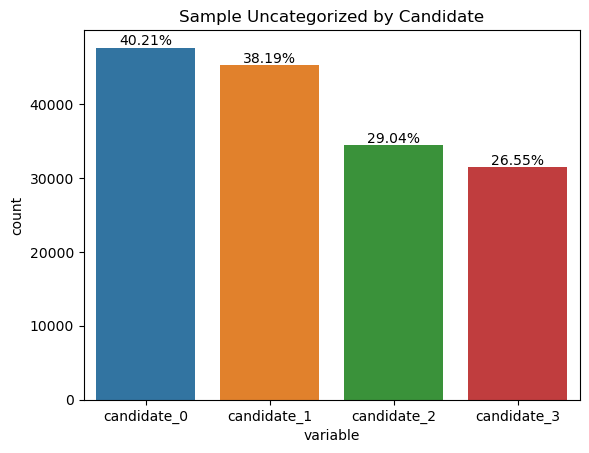

In [6]:
# Plot
tmp = labels.melt()
tmp = tmp[tmp["value"]<0]
ax = sns.countplot(tmp, x="variable")
for i, count in enumerate(ax.patches):
    _ = ax.annotate(f"{np.round(uncategorized_pct[i]*100,2)}%", (i, count.get_height()), ha='center', va='bottom')
_ = ax.set_title("Sample Uncategorized by Candidate")

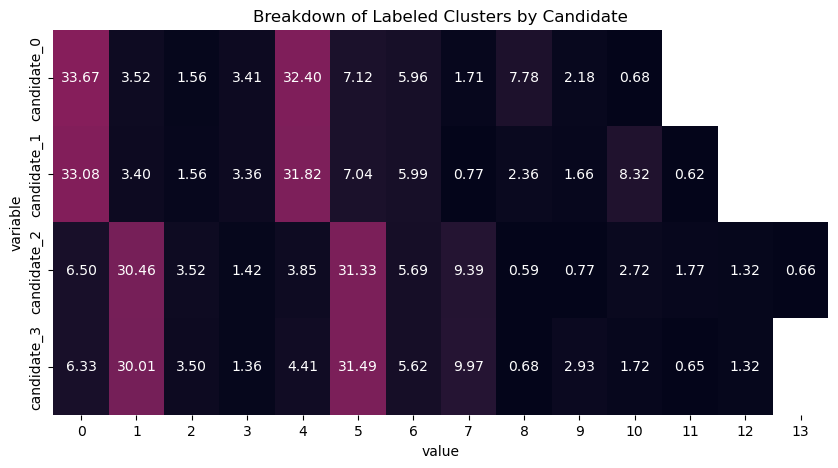

In [7]:
# Breakdown of categories?
tmp = labels.melt()[labels.melt()["value"]!=-1].reset_index()
tmp = tmp.pivot_table(index="variable", columns="value", values="index", aggfunc="count")
tmp = tmp.div(tmp.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(10,5))
_ = sns.heatmap(tmp*100, cbar=False, vmin=0, vmax=100, annot=True, fmt=".2f")
_ = ax.set_title("Breakdown of Labeled Clusters by Candidate")

## Profiler generation

In [8]:
# Recreate actor roles
actorroleinteractions = raw["actorroleinteraction"].str.split("-", expand=True)
actorroleinteractions.columns = ["actor1role", "actor2role"]
profiling_df = raw.merge(actorroleinteractions, left_index=True, right_index=True, how="left")

# Add features not used in clustering
right = RAW[["eventdate", "quadclass", "actor1geo_type", "actor1countrycode", "actor1geo_fullname", "actor2geo_type", "actor2countrycode", "actor2geo_fullname"]]
profiling_df = profiling_df.merge(right=right, left_index=True, right_index=True, how="left")

# Map features
# Source: http://data.gdeltproject.org/documentation/GDELT-Event_Codebook-V2.0.pdf
geotype_map = {1:"COUNTRY", 2:"USSTATE", 3:"USCITY", 4:"WORLDCITY", 5:"WORLDSTATE"}
profiling_df["actor1geo_type"] = profiling_df["actor1geo_type"].astype(int).map(geotype_map)
profiling_df["actor1geo_type"].value_counts(normalize=True, dropna=False)
profiling_df["actor2geo_type"] = profiling_df["actor2geo_type"].astype(int).map(geotype_map)
profiling_df["actor2geo_type"].value_counts(normalize=True, dropna=False)

quadclass_map = {1:"VERBAL COOPERATION", 2:"MATERIAL COOPERATION", 3:"VERBAL CONFLICT", 4:"MATERIAL CONFLICT"}
profiling_df["quadclass"] = profiling_df["quadclass"].map(quadclass_map)
profiling_df["quadclass"].value_counts(normalize=True, dropna=False)

# Findings from profiling: local governance events
profiling_df["wps_related"] = profiling_df["headline"].str.replace(" ", "").str.contains("SOUTHCHINASEA|WESTPHILIPPINESEA|WESTPHILIPPINESSEA|WPS|COASTGUARD|SEADISPUTE")
profiling_df["local_governance"] = (profiling_df["actor1name"] == "PHILIPPINE") & (profiling_df["actor2name"].isna())
def get_power_code(row):
    geo1, geo2 = row.actor1countrycode, row.actor2countrycode
    if geo1=="PHL":
        if pd.isna(geo2):
            power_code = 0  # Neutral
        elif geo2=="PHL":
            power_code = 0  # Neutral
        else:
            power_code = 1  # PH on giving end
    else:
        power_code = -1  # PH on receiving end
    return power_code
profiling_df["power_code"] =  profiling_df.apply(get_power_code, axis=1)

profiling_df = profiling_df.merge(labels, left_index=True, right_index=True)
profiling_df.to_csv("../results/profiling/profiling.csv", quoting=csv.QUOTE_ALL)

actor1geo_type
WORLDCITY     0.637870
COUNTRY       0.195866
NaN           0.092184
WORLDSTATE    0.049682
USCITY        0.015662
USSTATE       0.008735
Name: proportion, dtype: float64

actor2geo_type
WORLDCITY     0.523316
NaN           0.244686
COUNTRY       0.169998
WORLDSTATE    0.039705
USCITY        0.014438
USSTATE       0.007857
Name: proportion, dtype: float64

quadclass
MATERIAL COOPERATION    0.266778
VERBAL COOPERATION      0.254891
VERBAL CONFLICT         0.247474
MATERIAL CONFLICT       0.230857
Name: proportion, dtype: float64

## Association of features to clusters per candidate

### Linear association

In [9]:
# Get association of features to df
associations = pd.DataFrame()

for i in range(len(candidate_map)):
    # Isolate rows where samples belongs to a group
    candidate = f"candidate_{i}"
    subset = df[labels[candidate]!=-1]
    
    clusters = [c for c in labels[candidate].unique().tolist() if c!=-1]
    for cluster in clusters:
        subset_ = subset.copy()
        subset_["is_cluster"] = labels[candidate]==cluster  # Series of bool flags

        associations[f"{candidate}_cluster_{cluster}"] = subset_.select_dtypes([np.number, bool]).corr()["is_cluster"]

#### Interpret

In [10]:
def interpret(r):
    dir = "Positive" if r>0.2 else ("Negative" if r<-0.2 else "Neutral")
    if dir=="Neutral":
        return dir
    else:
        r = abs(r)
        if r >= 0.8:
            mod = "Very Strongly"
        elif r >= 0.6:
            mod = "Strongly"
        elif r >= 0.4:
            mod = "Moderately"
        else:
            mod = "Weakly"
        return f"{mod} {dir}"

In [11]:
tmp = associations.iloc[:-1,].applymap(interpret).melt(ignore_index=False).reset_index()
tmp = tmp.groupby(["variable", "value"])["index"].agg(lambda ser: ser.tolist()).reset_index().rename(columns={"index":"variables", "value":"interpretation"})
tmp["candidate"] = "candidate_" + tmp["variable"].apply(lambda x: re.findall("\d", x)[0])
tmp["cluster"] = "cluster_" + tmp["variable"].apply(lambda x: re.findall("\d", x)[1])
tmp = tmp[tmp["interpretation"]!="Neutral"]
tmp[["candidate", "cluster", "interpretation", "variables"]].to_csv("../results/profiling/interpreted_associations.csv")

#### Plot

In [12]:
# Custom color palette representing the ranges for correlation
ranges = [1, 0.8, 0.6, 0.4, 0.2, -0.2, -0.4, -0.6, -0.8, -1]
colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#f7f7f7', '#92c5de', '#4393c3', '#2166ac', '#053061']
corr_cmap = sns.diverging_palette(20, 220, sep=20, as_cmap=True, n=len(colors))

In [13]:
def plot_cluster_associations(candidate):
    candidate_cols = sorted([c for c in associations.columns if c.startswith(candidate)])
    corrs = associations[candidate_cols].dropna(axis=1).iloc[:-1,]
    corrs.columns = corrs.columns.map(lambda x: x.replace(f"{candidate}_", ""))
    corrs = corrs[[f"cluster_{c}" for c in range(corrs.shape[1])]]

    fig, ax = plt.subplots(1, 1, figsize=(12,12))
    _ = sns.heatmap(corrs, vmin=-1, vmax=1, center=0, cmap=corr_cmap, cbar=False, annot=True, fmt=".2f", ax=ax)
    _ = ax.set_title(candidate)

    _ = fig.savefig(f"../results/profiling/figures/cluster_associations_{candidate}.png")

[None, None, None, None]

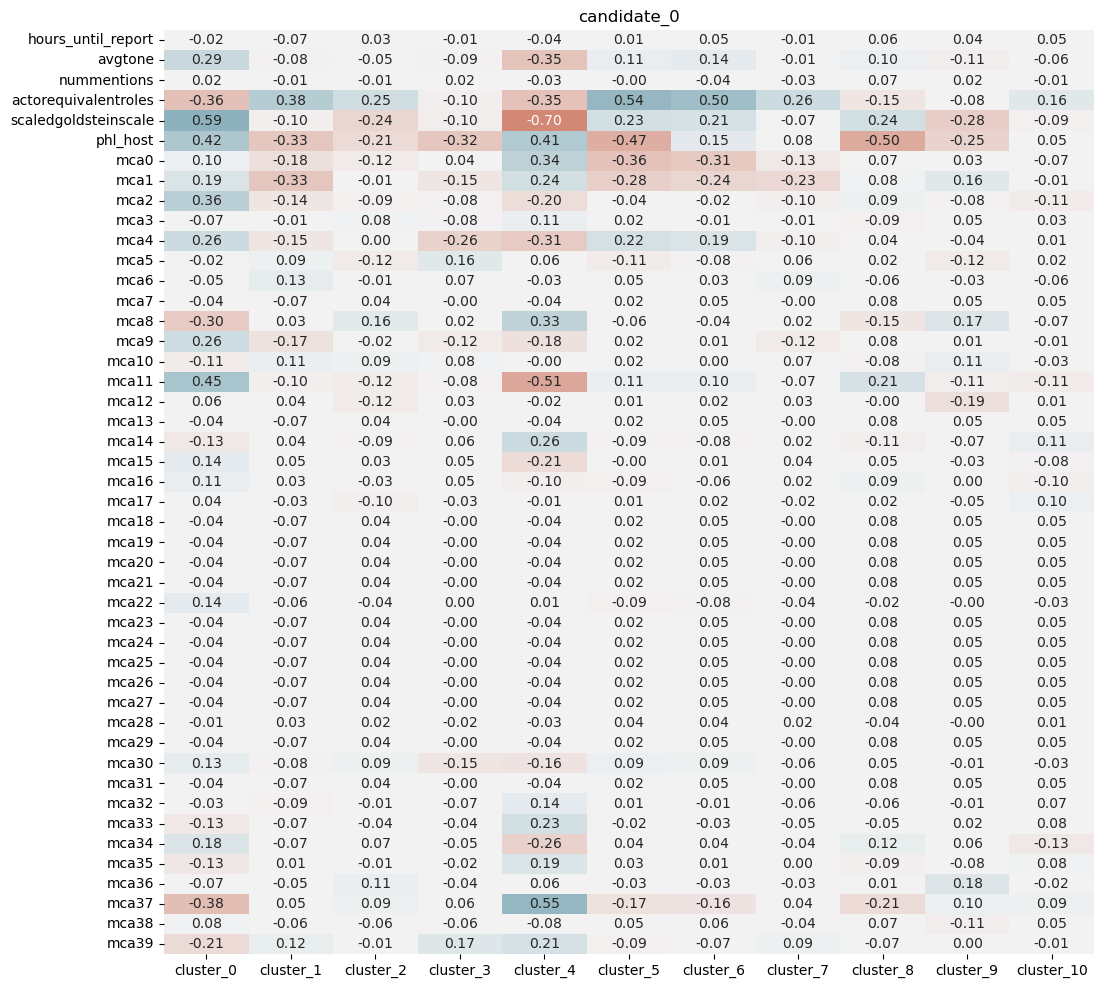

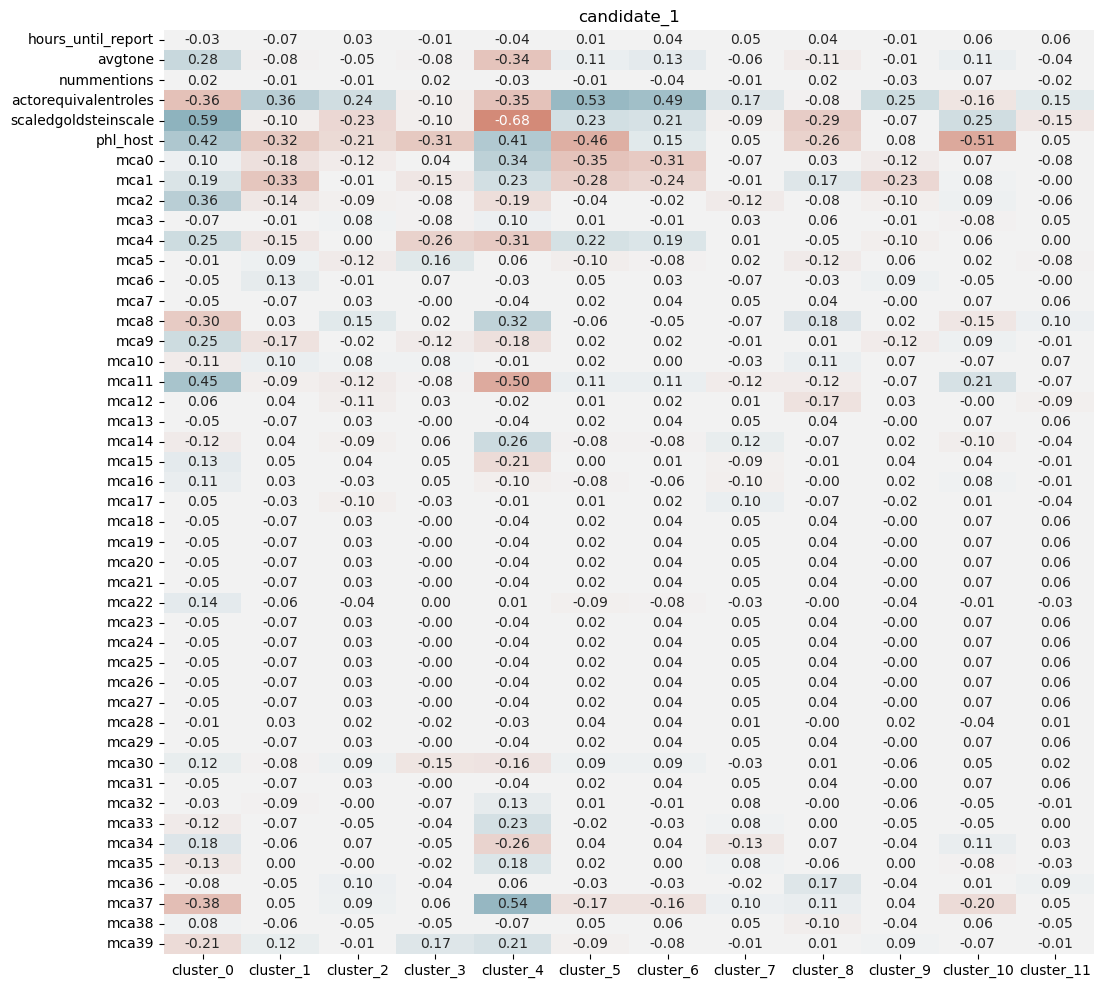

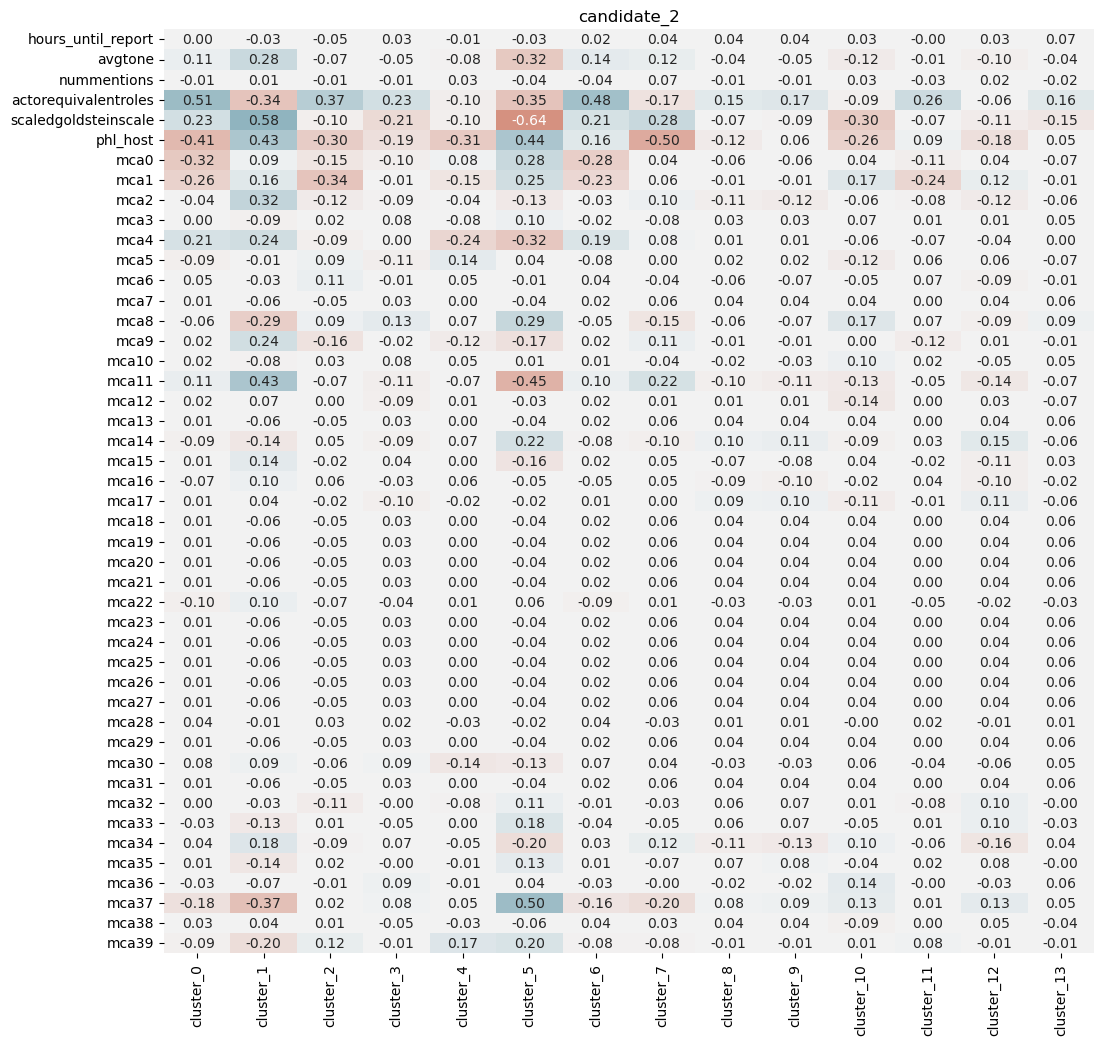

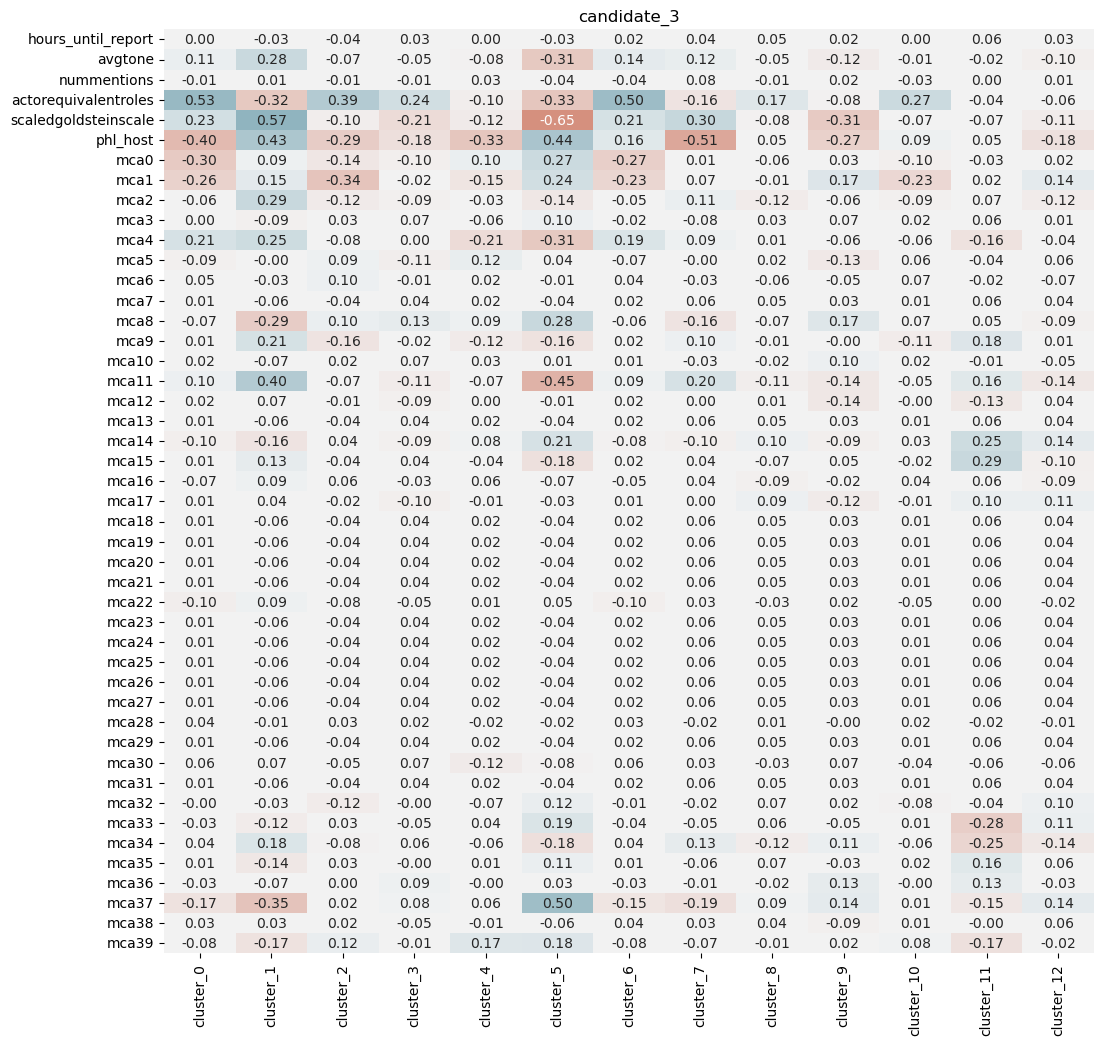

In [14]:
[plot_cluster_associations(candidate) for candidate in candidate_map.keys()]

### Distribution of vectors

In [15]:
labeled_matrix = matrix.merge(labels, left_index=True, right_index=True)

In [16]:
def plot_vectors_dists_per_cluster(candidate):
    tmp = labeled_matrix[labeled_matrix[candidate]!=-1]

    ncols = 6
    nrows = int(np.ceil(matrix.shape[1]/ncols))
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, figsize=(32,24))

    for i, feature in enumerate(matrix.columns):
        ax = axes[i//ncols, i%ncols]
        _ = sns.boxplot(data=tmp, x=candidate, y=feature, ax=ax)
        _ = ax.set_title(feature)
        _ = ax.set_xlabel("")
        _ = ax.set_ylabel("")

    i += 1
    for j in range((nrows * ncols) - matrix.shape[1]):
        ax = axes[(i+j)//ncols, (i+j)%ncols]
        ax.axis("off")

    _ = fig.suptitle(candidate)
    _ = fig.savefig(f"../results/profiling/figures/vectors_dists_per_cluster_{candidate}.png")

[None, None, None, None]

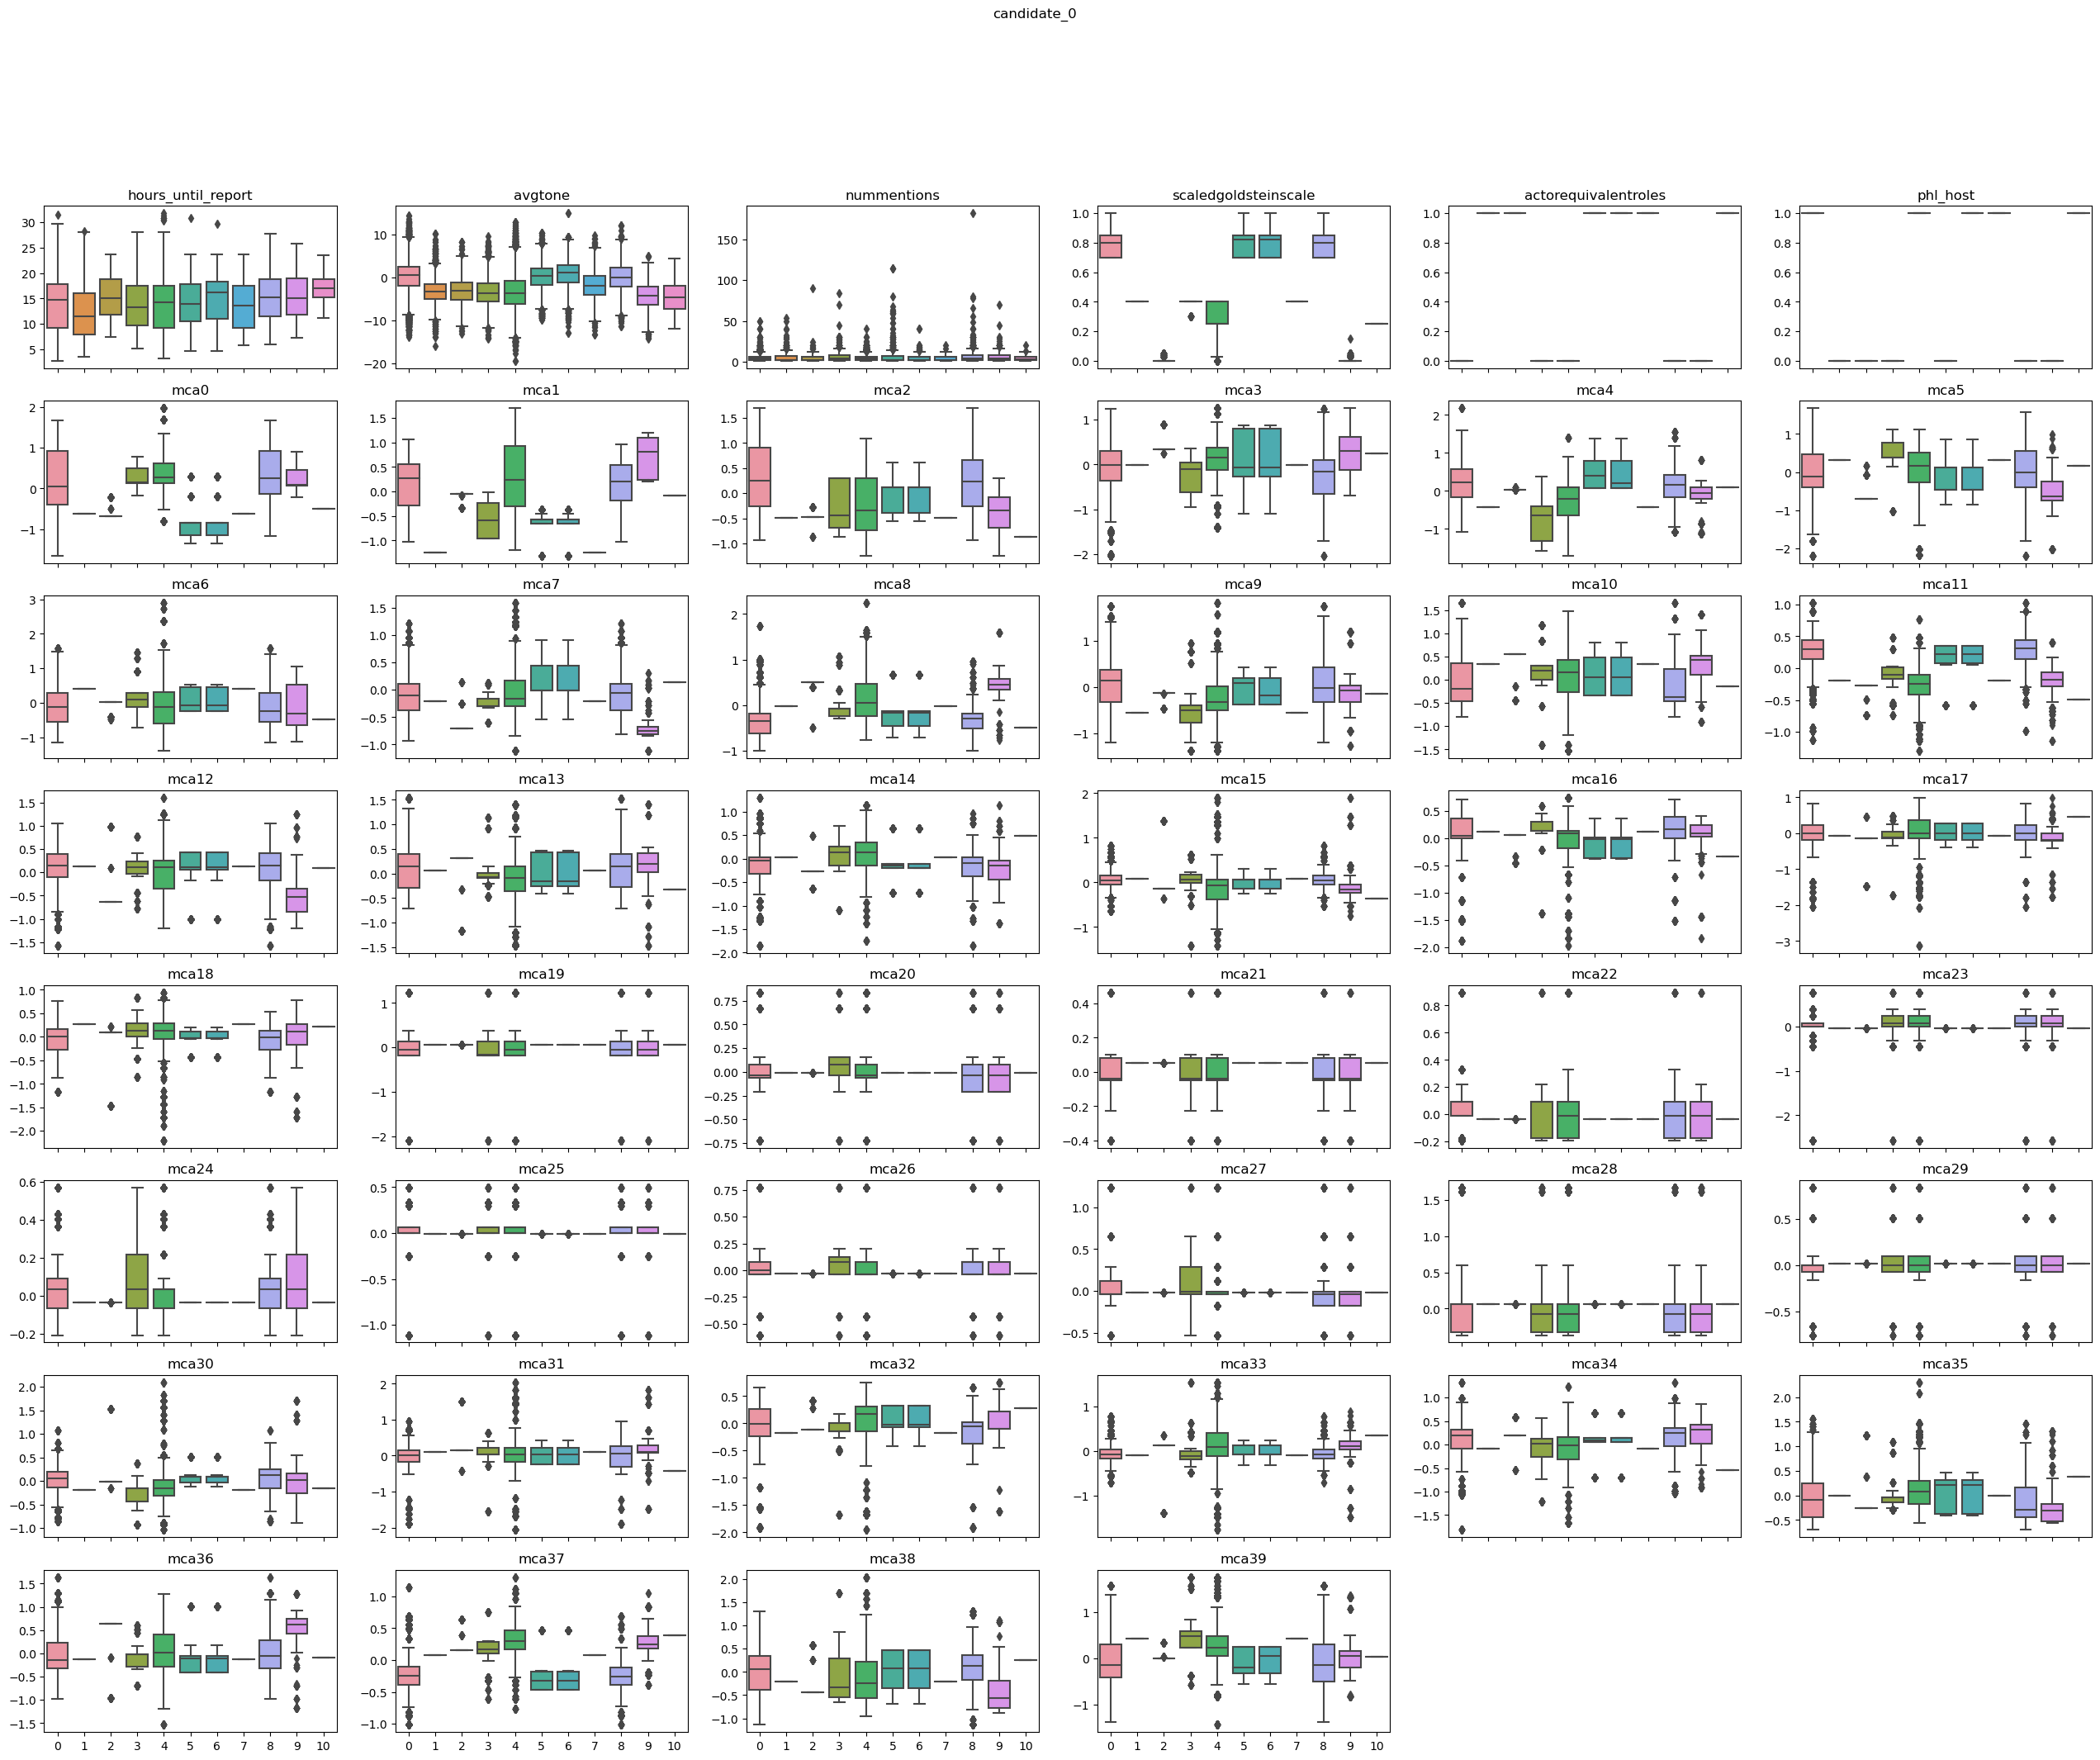

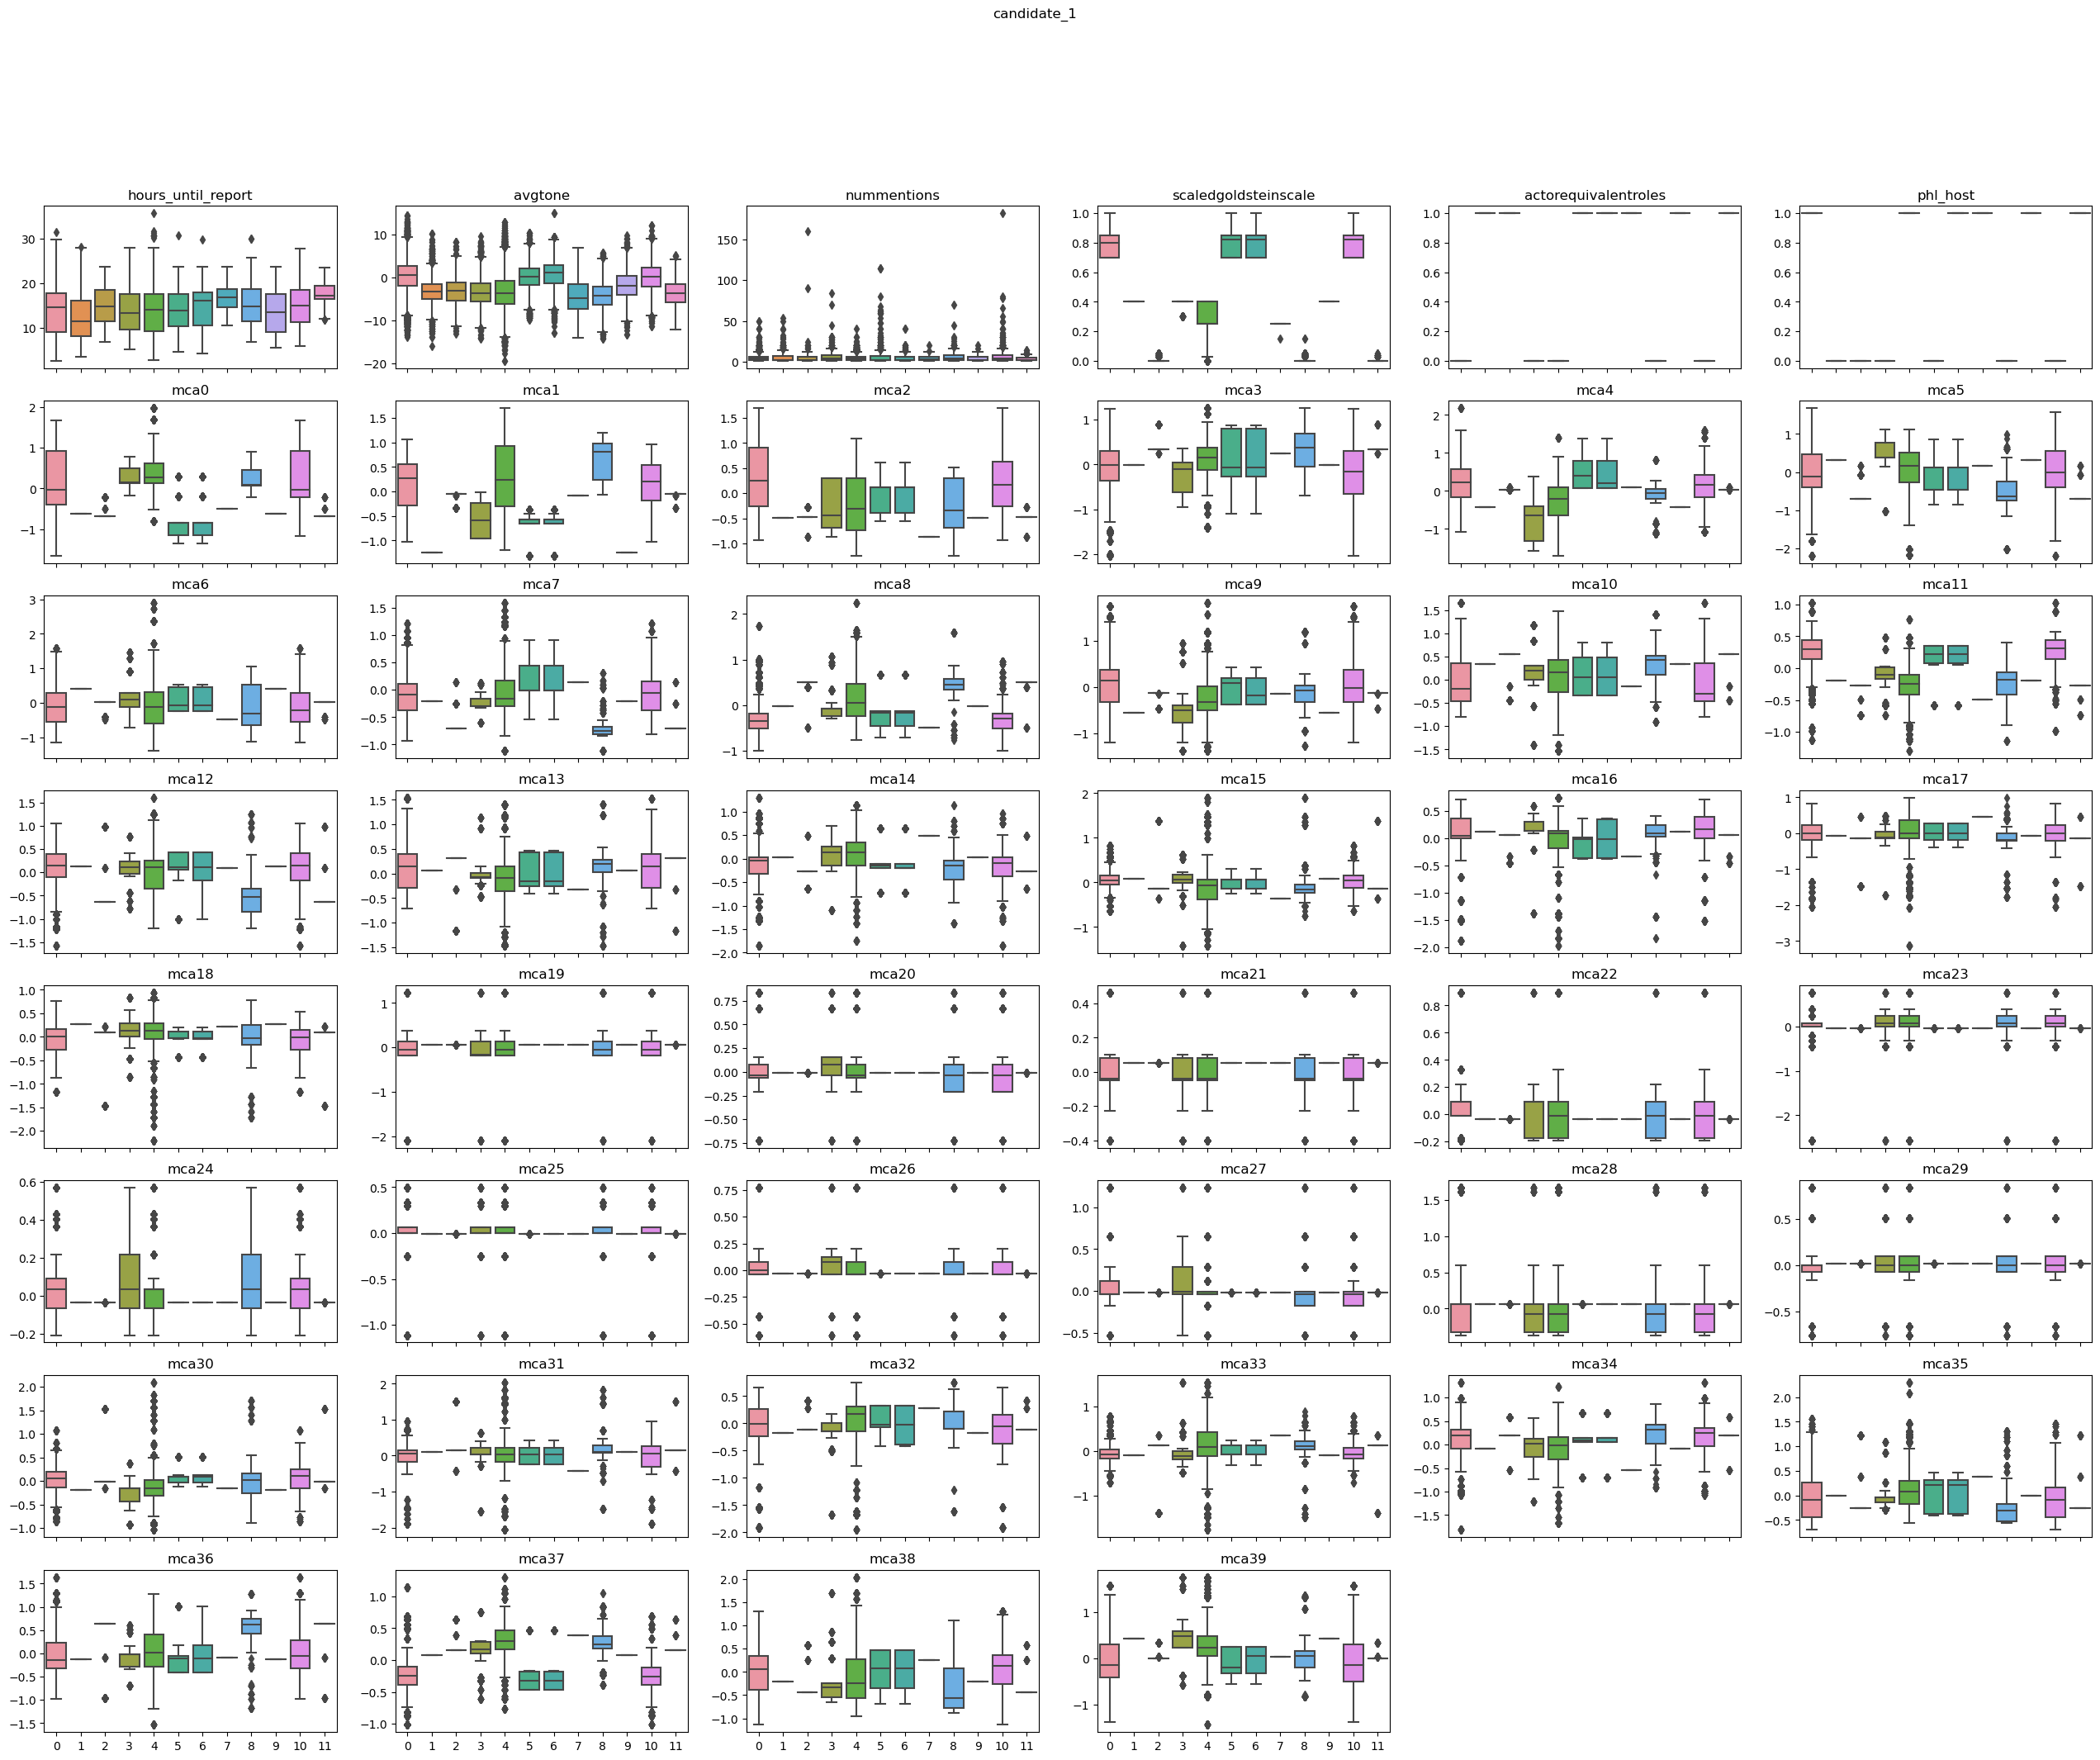

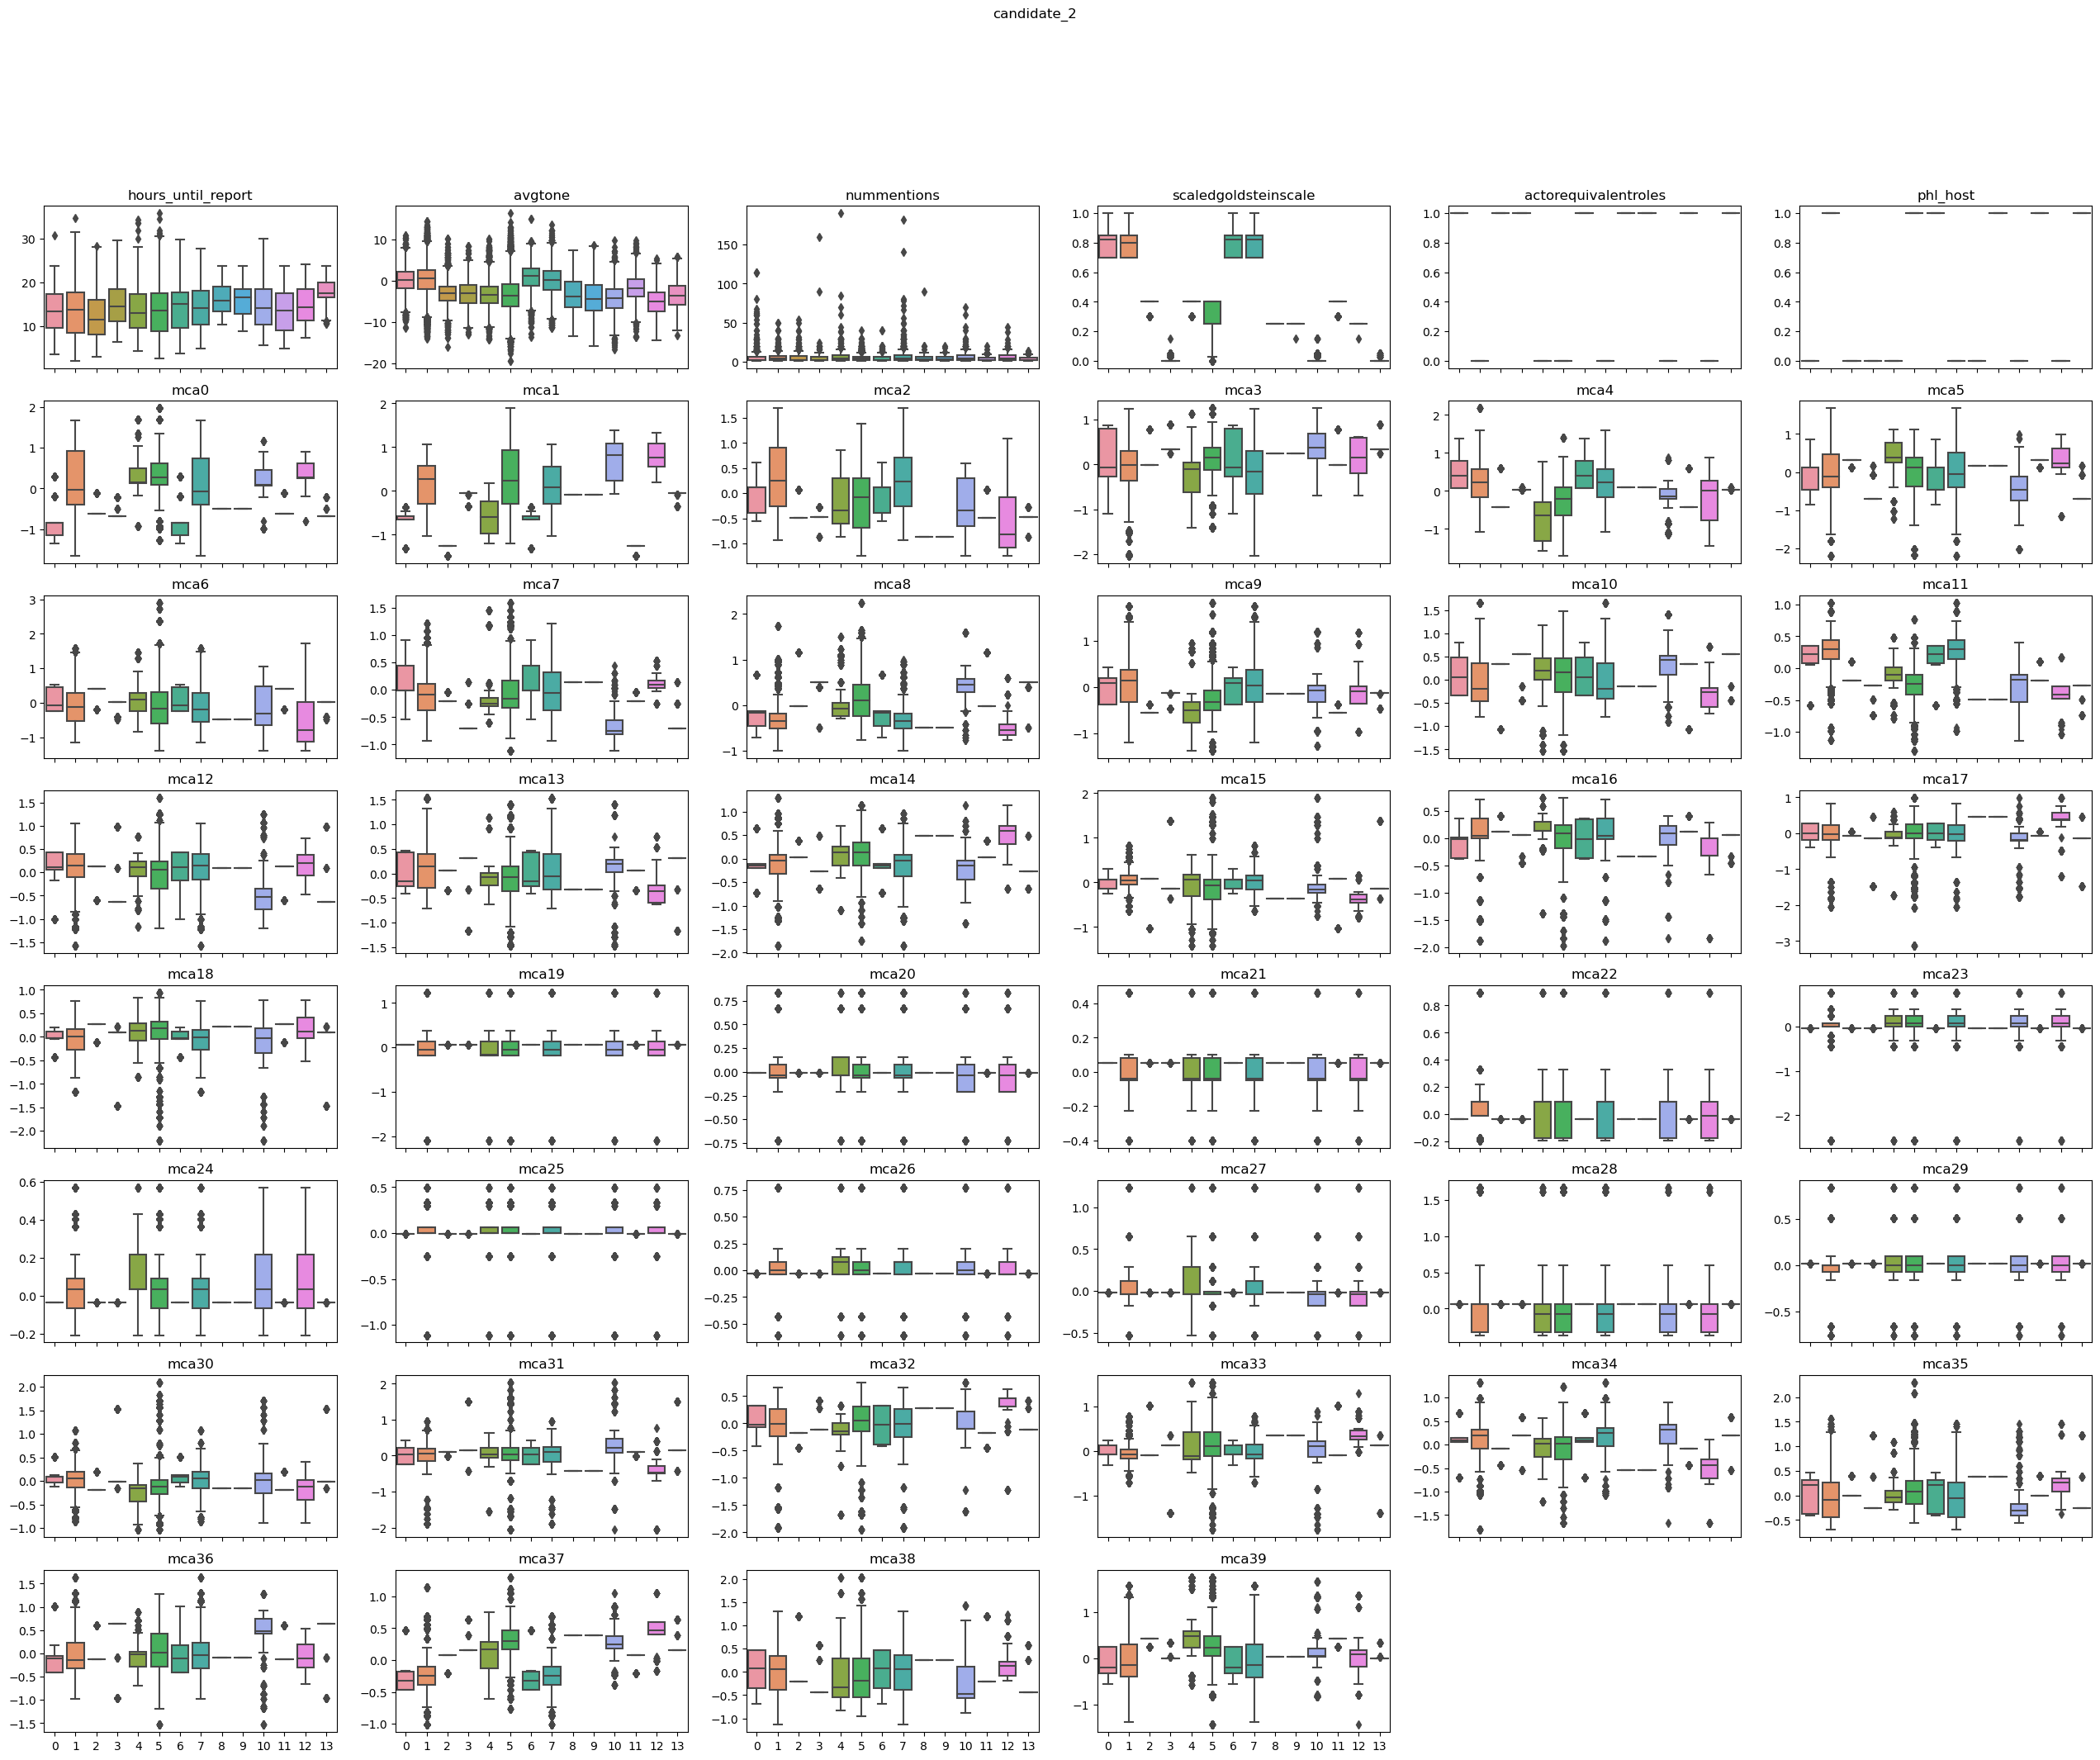

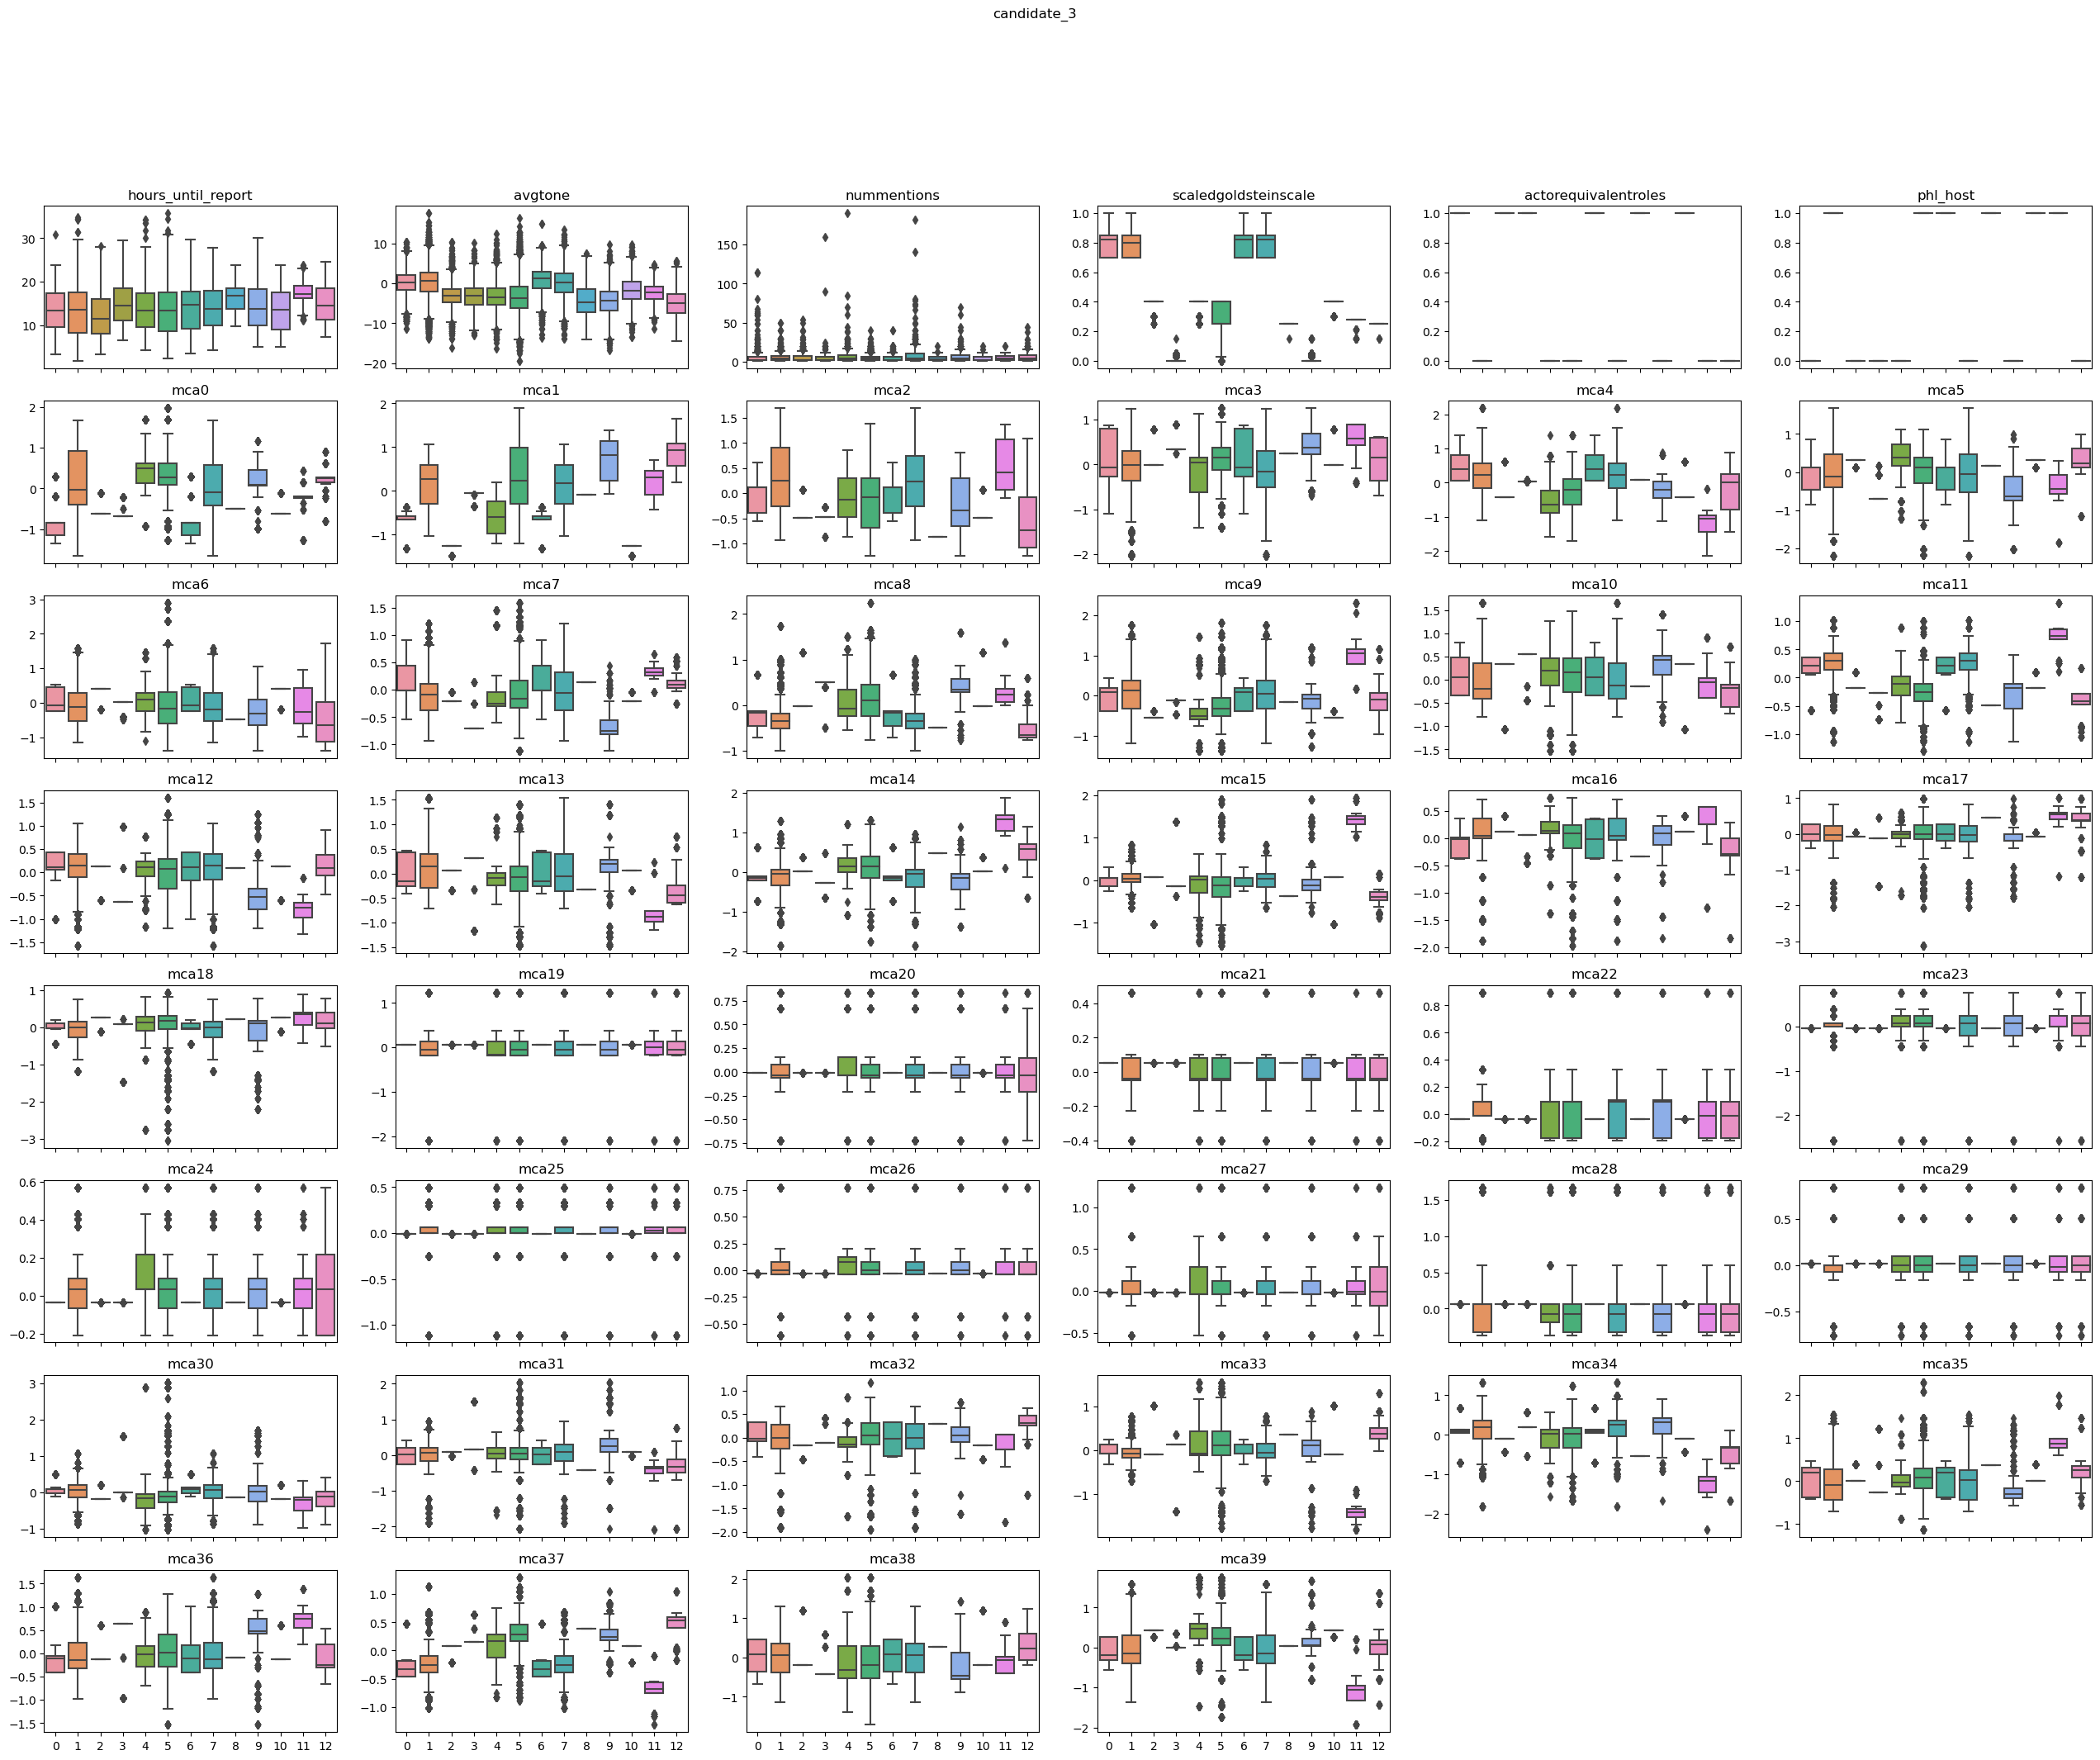

In [17]:
[plot_vectors_dists_per_cluster(candidate) for candidate in candidate_map.keys()]

## Distribution of categories

In [18]:
# Isolate profiling cols with <10 categories
cat_cols = profiling_df.select_dtypes("O").nunique()[profiling_df.select_dtypes("O").nunique()<10].index.tolist()
bool_cols = ["phl_host", "actorequivalentroles", "local_governance"]
cat_cols, bool_cols

(['actor1role', 'actor2role', 'quadclass', 'actor1geo_type', 'actor2geo_type'],
 ['phl_host', 'actorequivalentroles', 'local_governance'])

In [19]:
def plot_cat_dists_per_cluster(candidate):
    fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(20,10))
    _ = fig.subplots_adjust(hspace=0.25)
    tmp = profiling_df[profiling_df[candidate]>=0]
    # Plot cats
    for i, cat_col in enumerate(cat_cols):
        ax = axes[i//2, i%2]
        piv = tmp.pivot_table(index=cat_col, columns=candidate, values="headline", aggfunc="count")
        piv = piv.div(piv.sum(axis=0), axis=1).multiply(100)
        _ = sns.heatmap(piv, cbar=False, vmin=0, vmax=100, annot=True, ax=ax)
    # Plot bools
    piv = tmp.groupby(candidate)[bool_cols].mean().T.multiply(100)
    _ = sns.heatmap(piv, cbar=False, vmin=0, vmax=100, annot=True, ax=axes[-1,-1])
    _ = fig.savefig(f"../results/profiling/figures/cat_dists_per_cluster_{candidate}.png")

[None, None, None, None]

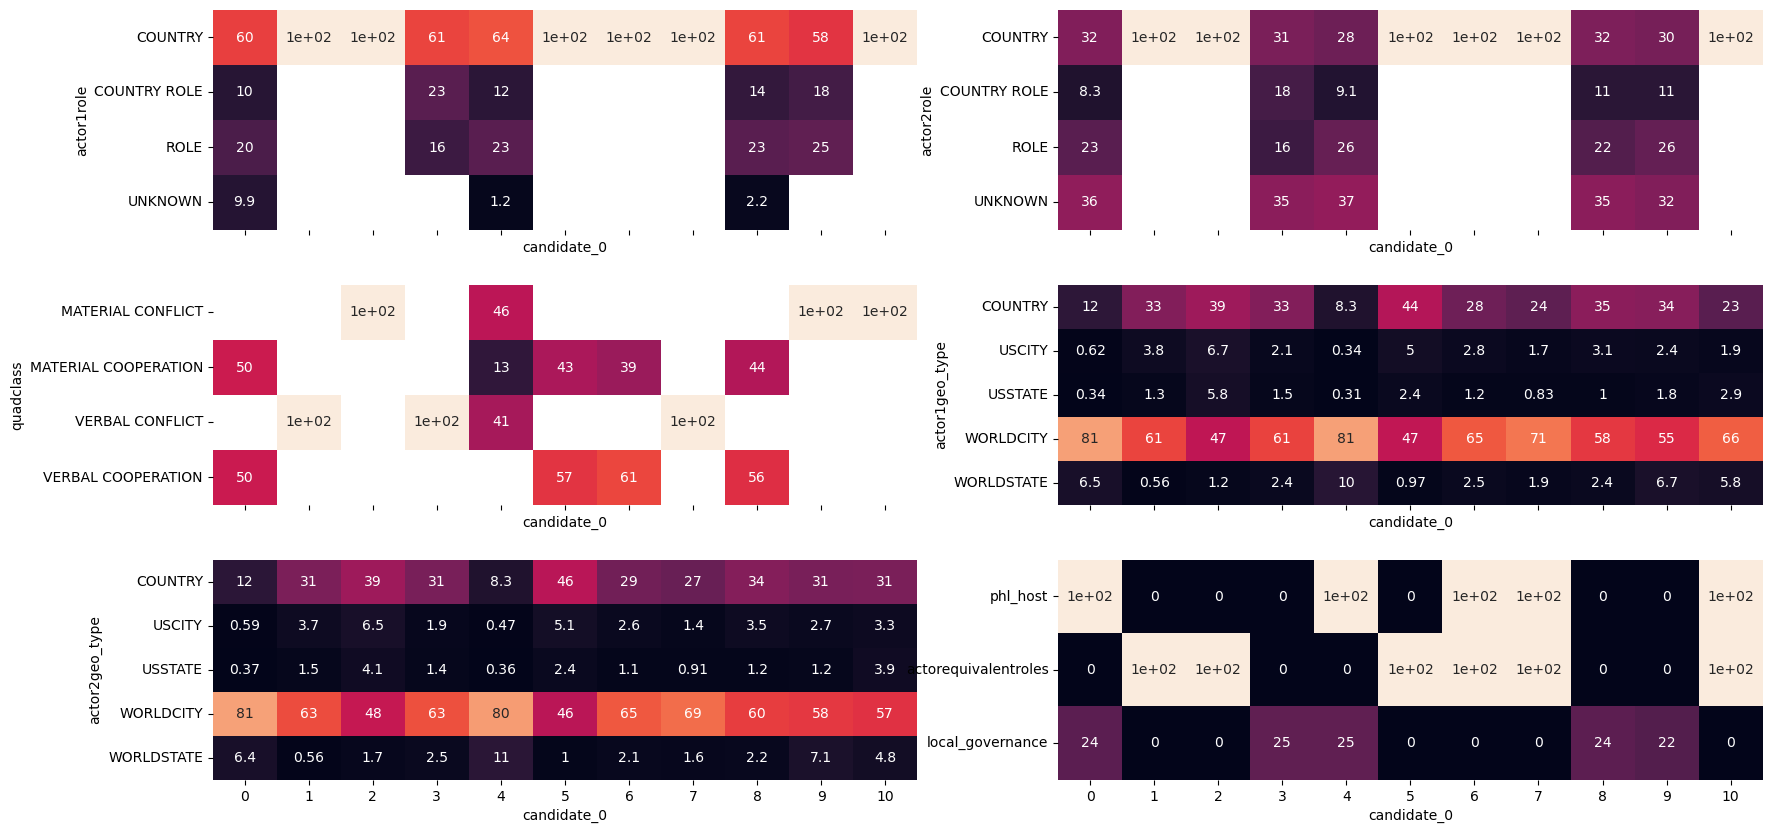

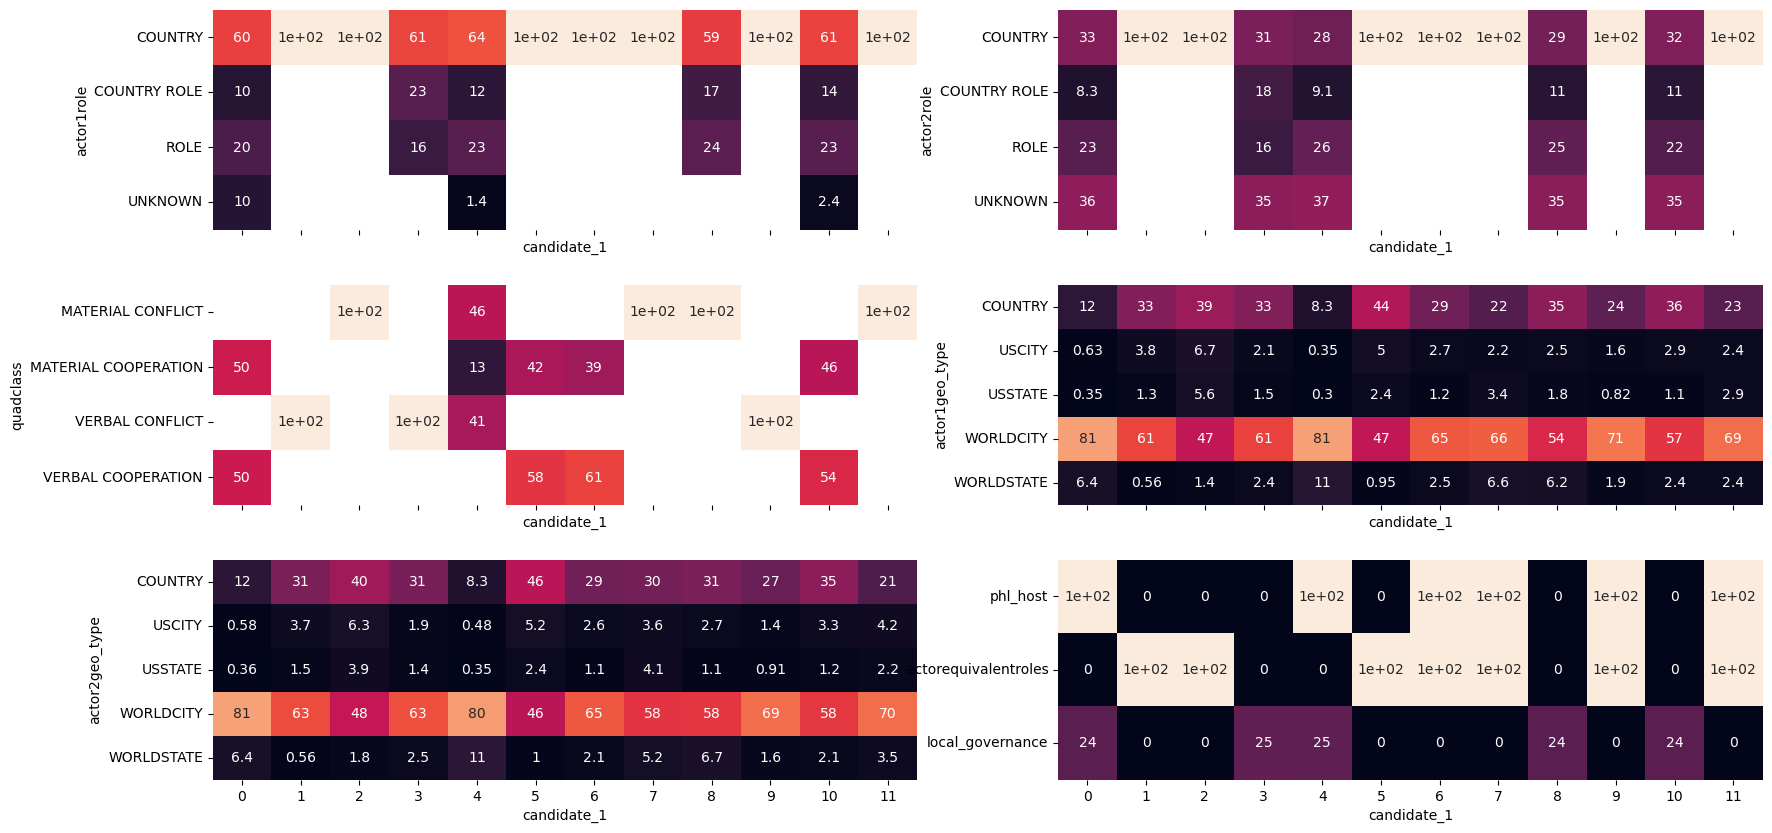

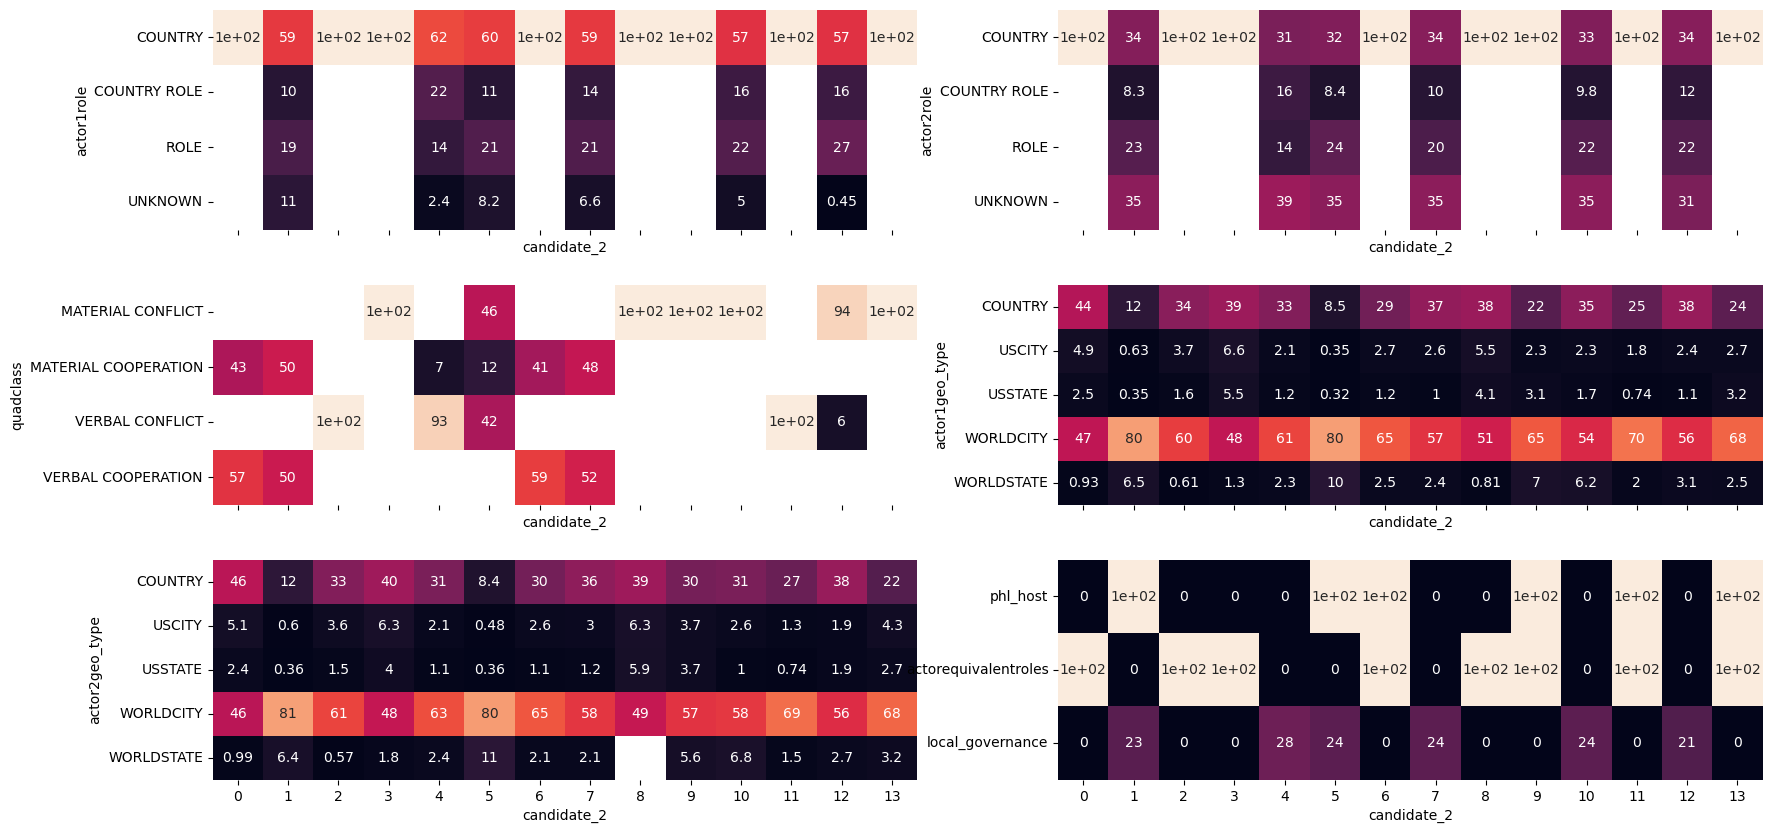

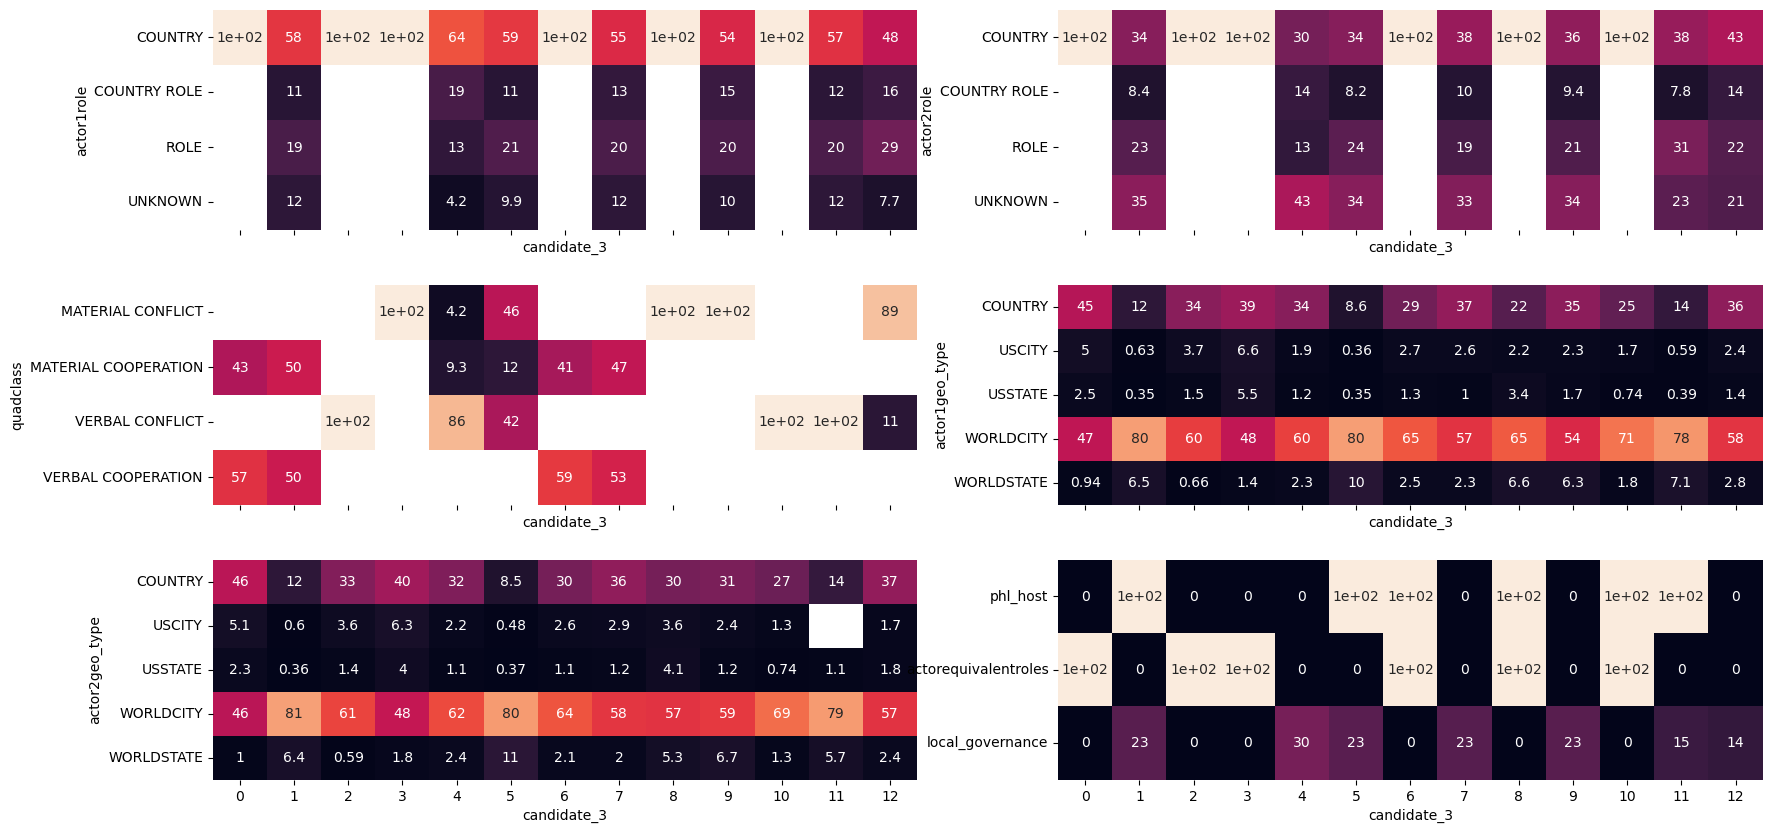

In [20]:
[plot_cat_dists_per_cluster(candidate) for candidate in candidate_map.keys()]

In [21]:
more_cols = ["power_code", "wps_related"]
profiling_df.groupby("candidate_0")[more_cols].mean().reset_index()
profiling_df.groupby("candidate_1")[more_cols].mean().reset_index()
profiling_df.groupby("candidate_2")[more_cols].mean().reset_index()
profiling_df.groupby("candidate_3")[more_cols].mean().reset_index()

candidate_0  power_code  wps_related
0            -1   -0.268411     0.044311
1             0   -0.279486     0.011958
2             1    0.232624     0.225392
3             2   -0.067151     0.065336
4             3   -0.040563     0.106788
5             4   -0.231380     0.010640
6             5   -0.043038     0.049583
7             6    0.028917     0.048353
8             7    0.104132     0.128926
9             8   -0.230713     0.038119
10            9   -0.238157     0.031798
11           10    0.142562     0.024793

candidate_1  power_code  wps_related
0            -1   -0.274312     0.045151
1             0   -0.280107     0.011857
2             1    0.232129     0.225301
3             2   -0.071678     0.070804
4             3   -0.039056     0.107404
5             4   -0.231466     0.010738
6             5   -0.039775     0.050640
7             6    0.031942     0.047456
8             7    0.133929     0.025000
9             8   -0.222094     0.031232
10            9    0.101235     0.128395
11           10   -0.232474     0.037432
12           11   -0.080963     0.010941

candidate_2  power_code  wps_related
0            -1   -0.258422     0.048321
1             0   -0.035701     0.049249
2             1   -0.290393     0.011881
3             2    0.238256     0.212234
4             3   -0.057935     0.069689
5             4   -0.045412     0.097003
6             5   -0.280704     0.010830
7             6    0.022589     0.047480
8             7   -0.245372     0.036520
9             8    0.068826     0.054656
10            9    0.124417     0.023328
11           10   -0.248906     0.033683
12           11    0.096167     0.127102
13           12   -0.257194     0.028777
14           13   -0.075269     0.019713

candidate_3  power_code  wps_related
0            -1   -0.215427     0.050786
1             0   -0.038308     0.048838
2             1   -0.296140     0.011997
3             2    0.237032     0.208142
4             3   -0.060708     0.069983
5             4   -0.063364     0.089179
6             5   -0.295402     0.010992
7             6    0.020471     0.046469
8             7   -0.288548     0.035521
9             8    0.133898     0.025424
10            9   -0.284984     0.033019
11           10    0.100402     0.128514
12           11   -0.332155     0.019435
13           12   -0.346388     0.030461

## Post-mortem

In [22]:
candidate = "candidate_0"

In [23]:
label_map = {
    0: 'Local Reports on National Development',
    4: 'Controversial Criminal Probes and Apprehensions',
    8: 'Global Perspectives on International Relations and State-Building',
    5: 'Globalization and Expanded Trade',
    6: 'Economic Partnerships and Development',
    1: 'Worldwide Condemnation of Diplomatic Discords and Maritime Disputes',
    3: 'Internationally Recognized Lapses in Legal and Diplomatic Safeguards',
    9: 'Globally-Covered Deadly Geopolitical and Military Conflicts', 
    7: 'Patriotism and Government Sentiments',
    2: 'Foreigner-Penned Conflict Escalations from Diplomatic Tensions',
    10: 'Transnational Cooperation in Law Enforcement',
 }
profiling_df["label"] = profiling_df[candidate].map(label_map)

### Num cols

In [24]:
num_cols = raw.select_dtypes(np.number).columns.tolist()

for num_col in num_cols:
    print(num_col)
    profiling_df.groupby("label")[num_col].describe()

hours_until_report


count       mean  \
label                                                                    
Controversial Criminal Probes and Apprehensions     22932.0  13.715147   
Economic Partnerships and Development                4219.0  14.946077   
Foreigner-Penned Conflict Escalations from Dipl...   1102.0  15.276089   
Global Perspectives on International Relations ...   5509.0  15.139544   
Globalization and Expanded Trade                     5042.0  14.195409   
Globally-Covered Deadly Geopolitical and Milita...   1541.0  15.450844   
Internationally Recognized Lapses in Legal and ...   2416.0  13.743171   
Local Reports on National Development               23833.0  13.828337   
Patriotism and Government Sentiments                 1210.0  13.643595   
Transnational Cooperation in Law Enforcement          484.0  17.032025   
Worldwide Condemnation of Diplomatic Discords a...   2489.0  12.100241   

                                                         std    min    25%  \
label                                                                        
Controversial Criminal Probes and Apprehensions     5.180208   3.25   9.25   
Economic Partnerships and Development               4.723519   4.75  11.00   
Foreigner-Penned Conflict Escalations from Dipl...  4.426505   7.50  11.75   
Global Perspectives on International Relations ...  4.394158   6.00  11.50   
Globalization and Expanded Trade                    4.756919   4.75  10.50   
Globally-Covered Deadly Geopolitical and Milita...  4.318402   7.25  11.75   
Internationally Recognized Lapses in Legal and ...  4.729413   5.25   9.75   
Local Reports on National Development               5.353814   2.75   9.25   
Patriotism and Government Sentiments                4.856671   5.75   9.25   
Transnational Cooperation in Law Enforcement        2.968347  11.25  15.25   
Worldwide Condemnation of Diplomatic Discords a...  5.146272   3.50   8.00   

                                                       50%    75%    max  
label                                                                     
Controversial Criminal Probes and Apprehensions     14.250  17.50  31.75  
Economic Partnerships and Development               16.250  18.25  29.75  
Foreigner-Penned Conflict Escalations from Dipl...  15.000  18.75  23.75  
Global Perspectives on International Relations ...  15.250  18.75  27.75  
Globalization and Expanded Trade                    14.000  17.75  30.75  
Globally-Covered Deadly Geopolitical and Milita...  15.000  19.00  25.75  
Internationally Recognized Lapses in Legal and ...  13.250  17.50  28.00  
Local Reports on National Development               14.750  17.75  31.50  
Patriotism and Government Sentiments                13.625  17.50  23.75  
Transnational Cooperation in Law Enforcement        17.000  18.75  23.50  
Worldwide Condemnation of Diplomatic Discords a...  11.500  16.00  28.25

avgtone


count      mean  \
label                                                                   
Controversial Criminal Probes and Apprehensions     22932.0 -3.418781   
Economic Partnerships and Development                4219.0  0.816343   
Foreigner-Penned Conflict Escalations from Dipl...   1102.0 -3.066675   
Global Perspectives on International Relations ...   5509.0  0.031245   
Globalization and Expanded Trade                     5042.0  0.246957   
Globally-Covered Deadly Geopolitical and Milita...   1541.0 -4.302288   
Internationally Recognized Lapses in Legal and ...   2416.0 -3.209409   
Local Reports on National Development               23833.0  0.268161   
Patriotism and Government Sentiments                 1210.0 -1.687135   
Transnational Cooperation in Law Enforcement          484.0 -4.219163   
Worldwide Condemnation of Diplomatic Discords a...   2489.0 -3.146284   

                                                         std        min  \
label                                                                     
Controversial Criminal Probes and Apprehensions     4.022481 -19.444444   
Economic Partnerships and Development               3.160925 -12.903226   
Foreigner-Penned Conflict Escalations from Dipl...  3.109531 -13.000000   
Global Perspectives on International Relations ...  3.352545 -11.267606   
Globalization and Expanded Trade                    3.037744  -9.907121   
Globally-Covered Deadly Geopolitical and Milita...  3.315298 -14.285714   
Internationally Recognized Lapses in Legal and ...  3.601426 -14.155251   
Local Reports on National Development               3.557451 -13.957597   
Patriotism and Government Sentiments                3.522621 -13.368984   
Transnational Cooperation in Law Enforcement        3.723231 -11.842105   
Worldwide Condemnation of Diplomatic Discords a...  3.176440 -16.044776   

                                                         25%       50%  \
label                                                                    
Controversial Criminal Probes and Apprehensions    -6.137184 -3.677700   
Economic Partnerships and Development              -1.206434  1.149425   
Foreigner-Penned Conflict Escalations from Dipl... -5.237634 -3.032600   
Global Perspectives on International Relations ... -2.195122  0.000000   
Globalization and Expanded Trade                   -1.666667  0.329512   
Globally-Covered Deadly Geopolitical and Milita... -6.403941 -4.266212   
Internationally Recognized Lapses in Legal and ... -5.531453 -3.618526   
Local Reports on National Development              -1.927711  0.584795   
Patriotism and Government Sentiments               -3.999110 -1.860465   
Transnational Cooperation in Law Enforcement       -7.230472 -4.624432   
Worldwide Condemnation of Diplomatic Discords a... -4.935622 -3.321033   

                                                         75%        max  
label                                                                    
Controversial Criminal Probes and Apprehensions    -0.836666  12.909441  
Economic Partnerships and Development               2.912621  15.012723  
Foreigner-Penned Conflict Escalations from Dipl... -1.072052   8.333333  
Global Perspectives on International Relations ...  2.272727  12.154696  
Globalization and Expanded Trade                    2.200489  10.370370  
Globally-Covered Deadly Geopolitical and Milita... -2.097902   4.945055  
Internationally Recognized Lapses in Legal and ... -1.360544   9.638554  
Local Reports on National Development               2.617801  14.444444  
Patriotism and Government Sentiments                0.418410   9.800000  
Transnational Cooperation in Law Enforcement       -1.887035   4.455446  
Worldwide Condemnation of Diplomatic Discords a... -1.612903  10.290828

nummentions


count      mean  \
label                                                                   
Controversial Criminal Probes and Apprehensions     22932.0  4.451160   
Economic Partnerships and Development                4219.0  4.038635   
Foreigner-Penned Conflict Escalations from Dipl...   1102.0  4.195100   
Global Perspectives on International Relations ...   5509.0  5.448720   
Globalization and Expanded Trade                     5042.0  4.578540   
Globally-Covered Deadly Geopolitical and Milita...   1541.0  5.162232   
Internationally Recognized Lapses in Legal and ...   2416.0  5.094371   
Local Reports on National Development               23833.0  4.720178   
Patriotism and Government Sentiments                 1210.0  3.733884   
Transnational Cooperation in Law Enforcement          484.0  4.163223   
Worldwide Condemnation of Diplomatic Discords a...   2489.0  4.452391   

                                                         std  min  25%  50%  \
label                                                                         
Controversial Criminal Probes and Apprehensions     3.075946  1.0  2.0  4.0   
Economic Partnerships and Development               3.145617  1.0  2.0  2.0   
Foreigner-Penned Conflict Escalations from Dipl...  4.128175  1.0  2.0  2.0   
Global Perspectives on International Relations ...  5.020054  1.0  2.0  4.0   
Globalization and Expanded Trade                    5.343570  1.0  2.0  2.0   
Globally-Covered Deadly Geopolitical and Milita...  4.272643  1.0  2.0  4.0   
Internationally Recognized Lapses in Legal and ...  4.502793  1.0  2.0  4.0   
Local Reports on National Development               3.231610  1.0  2.0  4.0   
Patriotism and Government Sentiments                2.875456  1.0  2.0  2.0   
Transnational Cooperation in Law Enforcement        3.031274  1.0  2.0  3.0   
Worldwide Condemnation of Diplomatic Discords a...  4.025272  1.0  2.0  2.0   

                                                    75%    max  
label                                                           
Controversial Criminal Probes and Apprehensions     6.0   40.0  
Economic Partnerships and Development               6.0   40.0  
Foreigner-Penned Conflict Escalations from Dipl...  6.0   90.0  
Global Perspectives on International Relations ...  8.0  182.0  
Globalization and Expanded Trade                    7.0  114.0  
Globally-Covered Deadly Geopolitical and Milita...  8.0   70.0  
Internationally Recognized Lapses in Legal and ...  8.0   84.0  
Local Reports on National Development               6.0   50.0  
Patriotism and Government Sentiments                6.0   20.0  
Transnational Cooperation in Law Enforcement        6.0   20.0  
Worldwide Condemnation of Diplomatic Discords a...  7.0   54.0

scaledgoldsteinscale


count      mean  \
label                                                                   
Controversial Criminal Probes and Apprehensions     22932.0  0.259493   
Economic Partnerships and Development                4219.0  0.793854   
Foreigner-Penned Conflict Escalations from Dipl...   1102.0  0.008203   
Global Perspectives on International Relations ...   5509.0  0.791270   
Globalization and Expanded Trade                     5042.0  0.798852   
Globally-Covered Deadly Geopolitical and Milita...   1541.0  0.004620   
Internationally Recognized Lapses in Legal and ...   2416.0  0.397061   
Local Reports on National Development               23833.0  0.796576   
Patriotism and Government Sentiments                 1210.0  0.400000   
Transnational Cooperation in Law Enforcement          484.0  0.250000   
Worldwide Condemnation of Diplomatic Discords a...   2489.0  0.400000   

                                                             std   min   25%  \
label                                                                          
Controversial Criminal Probes and Apprehensions     1.517831e-01  0.00  0.25   
Economic Partnerships and Development               7.491015e-02  0.70  0.70   
Foreigner-Penned Conflict Escalations from Dipl...  1.637416e-02  0.00  0.00   
Global Perspectives on International Relations ...  7.511525e-02  0.70  0.70   
Globalization and Expanded Trade                    7.466064e-02  0.70  0.70   
Globally-Covered Deadly Geopolitical and Milita...  1.275144e-02  0.00  0.00   
Internationally Recognized Lapses in Legal and ...  1.689249e-02  0.30  0.40   
Local Reports on National Development               7.395171e-02  0.70  0.70   
Patriotism and Government Sentiments                8.607786e-15  0.40  0.40   
Transnational Cooperation in Law Enforcement        0.000000e+00  0.25  0.25   
Worldwide Condemnation of Diplomatic Discords a...  1.587938e-14  0.40  0.40   

                                                     50%   75%   max  
label                                                                 
Controversial Criminal Probes and Apprehensions     0.25  0.40  0.40  
Economic Partnerships and Development               0.82  0.85  1.00  
Foreigner-Penned Conflict Escalations from Dipl...  0.00  0.00  0.05  
Global Perspectives on International Relations ...  0.80  0.85  1.00  
Globalization and Expanded Trade                    0.82  0.85  1.00  
Globally-Covered Deadly Geopolitical and Milita...  0.00  0.00  0.15  
Internationally Recognized Lapses in Legal and ...  0.40  0.40  0.40  
Local Reports on National Development               0.80  0.85  1.00  
Patriotism and Government Sentiments                0.40  0.40  0.40  
Transnational Cooperation in Law Enforcement        0.25  0.25  0.25  
Worldwide Condemnation of Diplomatic Discords a...  0.40  0.40  0.40

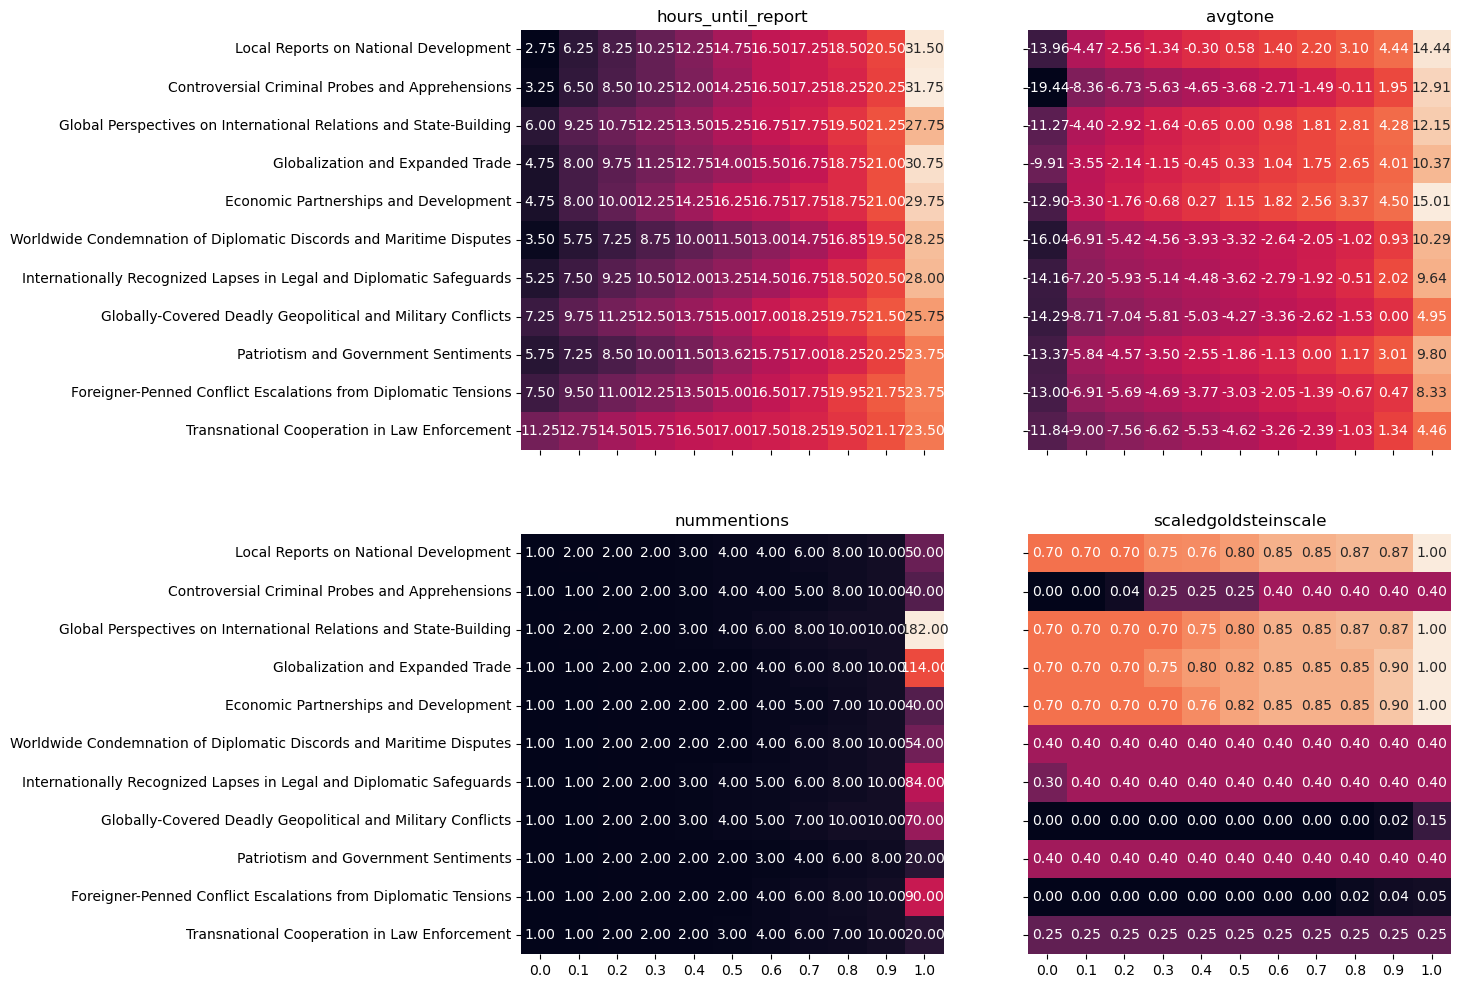

In [25]:
percentiles = [i/100 for i in range(0,101, 10)]
order = list(label_map.values())

fig, axes = plt.subplots(2, 2, figsize=(12,12), sharex=True, sharey=True)
for i, num_col in enumerate(num_cols):
    tmp = profiling_df.groupby("label")[num_col].quantile(q=percentiles).unstack().loc[order,]
    ax = axes[i//2, i%2]
    _ = sns.heatmap(tmp, annot=True, cbar=False, fmt=".2f", ax=ax)
    _ = ax.set_title(num_col)
    _ = ax.set_ylabel("")

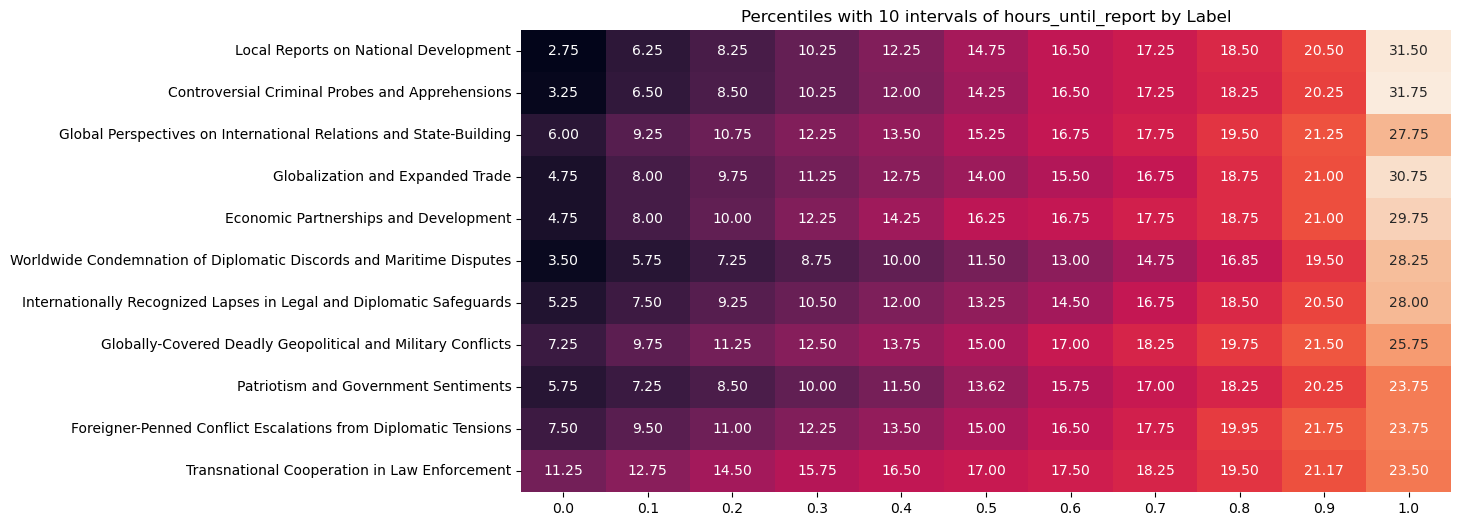

In [26]:
percentiles = [i/100 for i in range(0,101, 10)]
order = list(label_map.values())

fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True, sharey=True)
i = 0
num_col = num_cols[i]
tmp = profiling_df.groupby("label")[num_col].quantile(q=percentiles).unstack().loc[order,]
_ = sns.heatmap(tmp, annot=True, cbar=False, fmt=".2f")
_ = ax.set_title(f"Percentiles with 10 intervals of {num_col} by Label")
_ = ax.set_ylabel("")

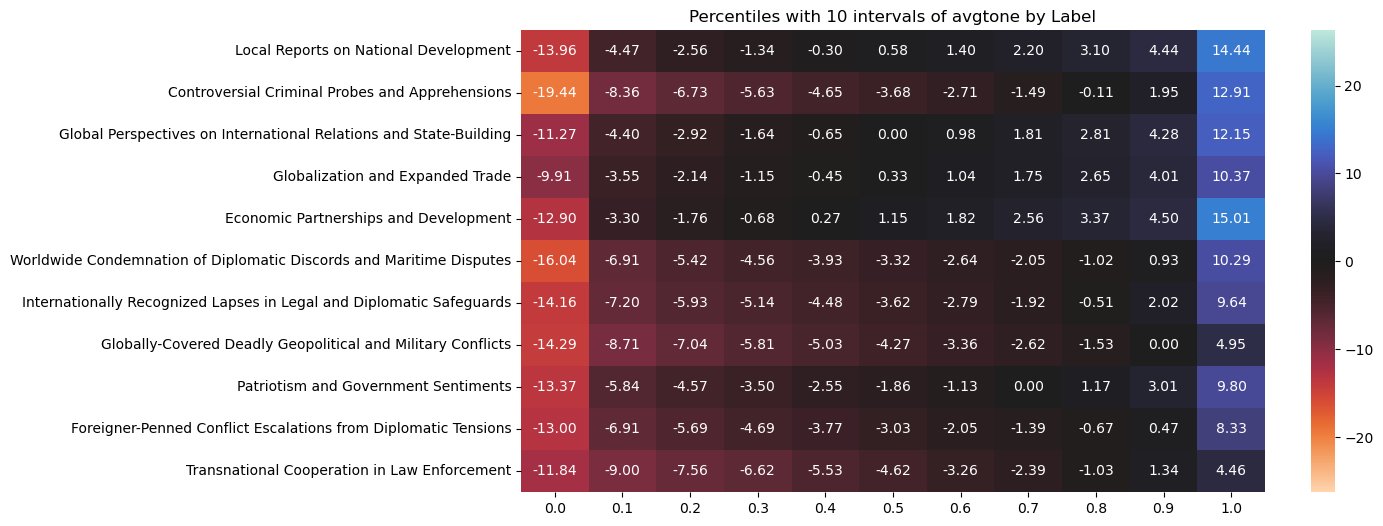

In [27]:
percentiles = [i/100 for i in range(0,101, 10)]
order = list(label_map.values())

fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True, sharey=True)
i = 1
num_col = num_cols[i]
tmp = profiling_df.groupby("label")[num_col].quantile(q=percentiles).unstack().loc[order,]
max_ = profiling_df[num_col].abs().max()
_ = sns.heatmap(tmp, annot=True, fmt=".2f", vmin=-1*max_, vmax=max_, center=0, cbar=True, cmap="icefire_r")
_ = ax.set_title(f"Percentiles with 10 intervals of {num_col} by Label")
_ = ax.set_ylabel("")

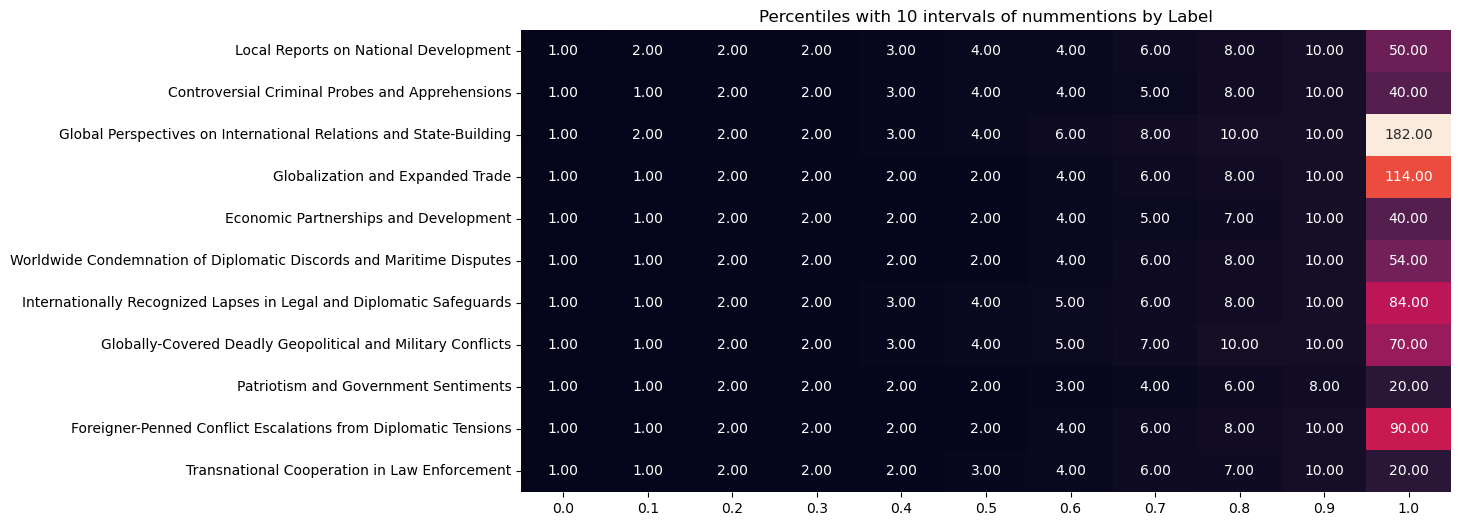

In [28]:
percentiles = [i/100 for i in range(0,101, 10)]
order = list(label_map.values())

fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True, sharey=True)
i = 2
num_col = num_cols[i]
tmp = profiling_df.groupby("label")[num_col].quantile(q=percentiles).unstack().loc[order,]
_ = sns.heatmap(tmp, annot=True, cbar=False, fmt=".2f", vmin=0)
_ = ax.set_title(f"Percentiles with 10 intervals of {num_col} by Label")
_ = ax.set_ylabel("")

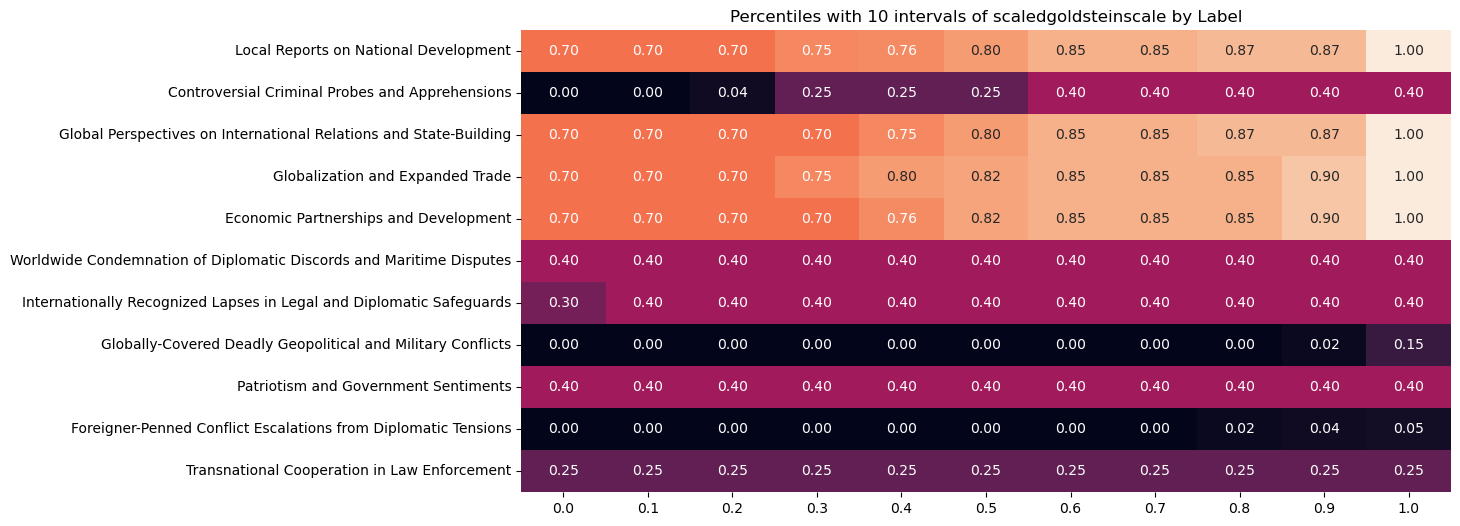

In [29]:
percentiles = [i/100 for i in range(0,101, 10)]
order = list(label_map.values())

fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True, sharey=True)
i = 3
num_col = num_cols[i]
tmp = profiling_df.groupby("label")[num_col].quantile(q=percentiles).unstack().loc[order,]
_ = sns.heatmap(tmp, annot=True, cbar=False, fmt=".2f", vmin=0, vmax=1)
_ = ax.set_title(f"Percentiles with 10 intervals of {num_col} by Label")
_ = ax.set_ylabel("")

### Bool cols

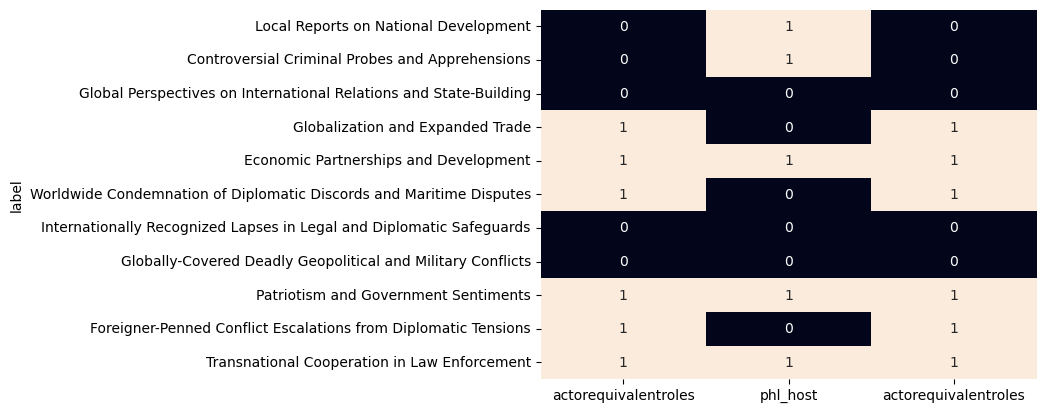

In [30]:
bool_cols = raw.select_dtypes(bool).columns.tolist() + ["actorequivalentroles"]
tmp = profiling_df.groupby("label")[bool_cols].mean().loc[order,]
_ = sns.heatmap(tmp, cbar=False, annot=True)

### Cat cols

In [31]:
cat_cols = ["actorroleinteraction", "eventrootdescription"]
order_map = {
    "actorroleinteraction" : sorted(profiling_df.dropna(subset=["label"])["actorroleinteraction"].unique().tolist()), 
    "eventrootdescription" : profiling_df.dropna(subset=["label"]).groupby("eventrootdescription")["scaledgoldsteinscale"].mean().sort_values().index.tolist()
}


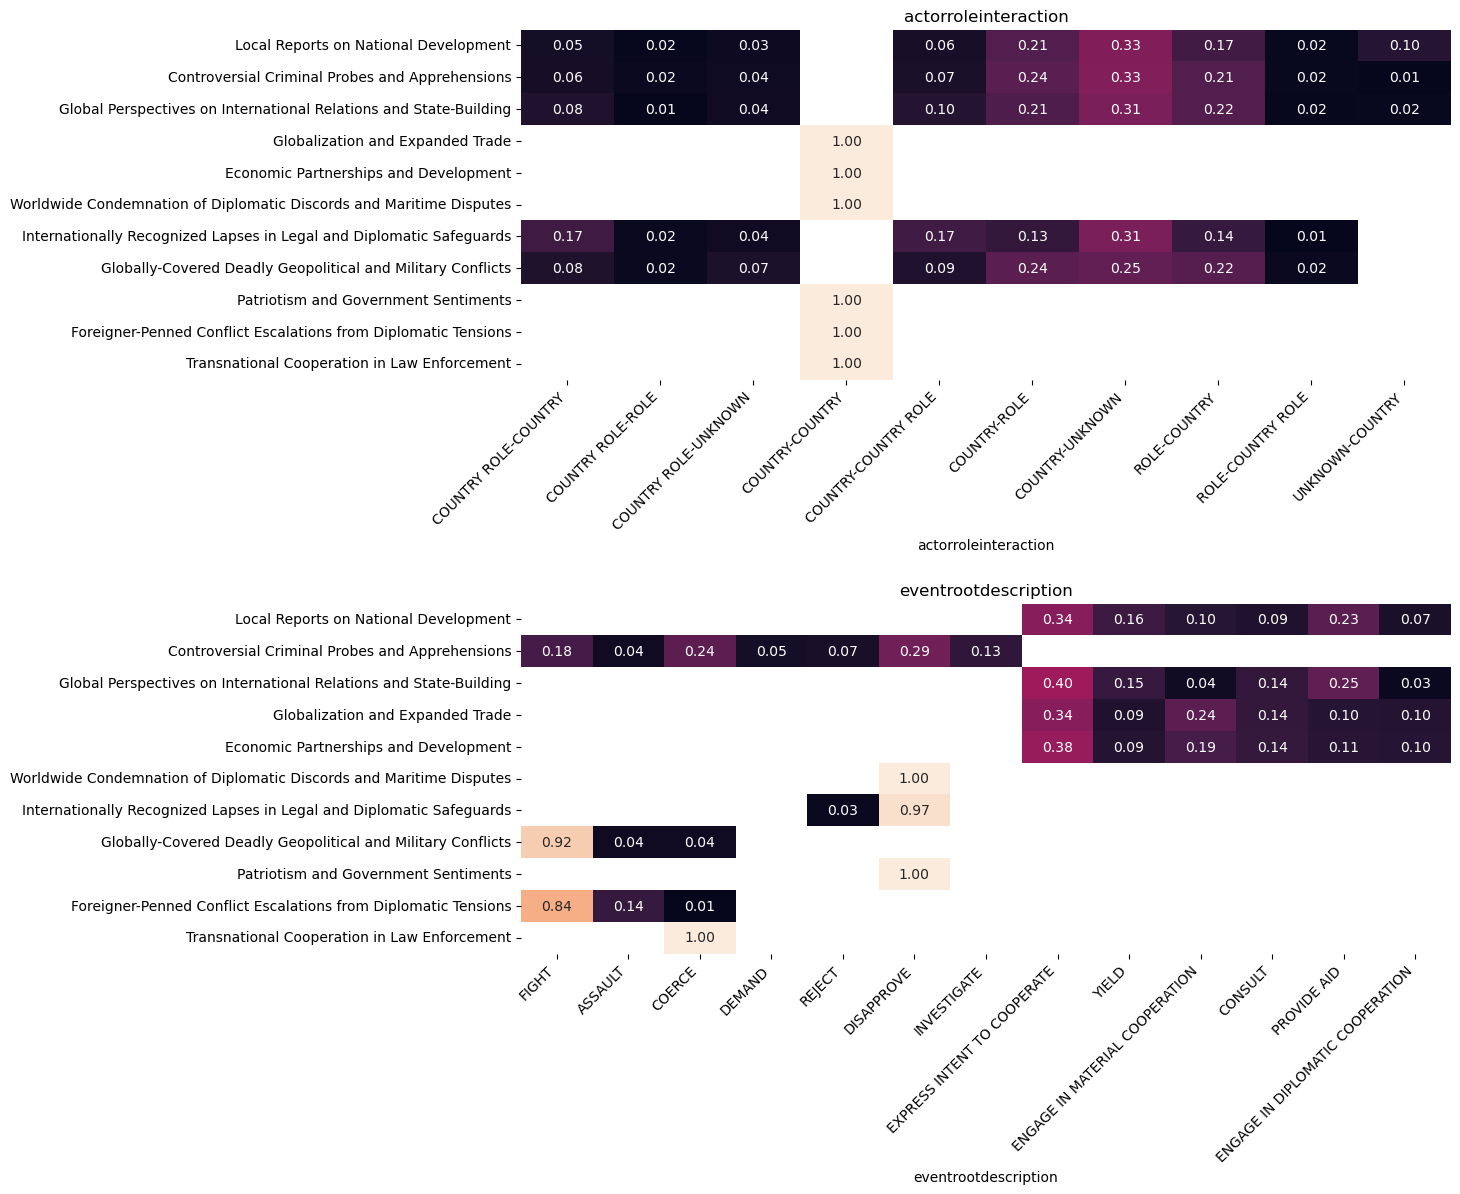

In [32]:
fig, axes = plt.subplots(nrows=2, figsize=(12,12))
_ = fig.subplots_adjust(hspace=.64)

for i, cat_col in enumerate(cat_cols):
    tmp = profiling_df.pivot_table(index="label", columns=cat_col, values=candidate, aggfunc="count").loc[order,]
    tmp = tmp.div(tmp.sum(axis=1), axis=0).loc[:, order_map[cat_col]]
    ax = axes[i]
    _ = sns.heatmap(tmp, annot=True, cbar=False, fmt=".2f", vmin=0, vmax=1, ax=ax)
    _ = ax.set_title(cat_col)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    _ = ax.set_ylabel("")

### Desc cols

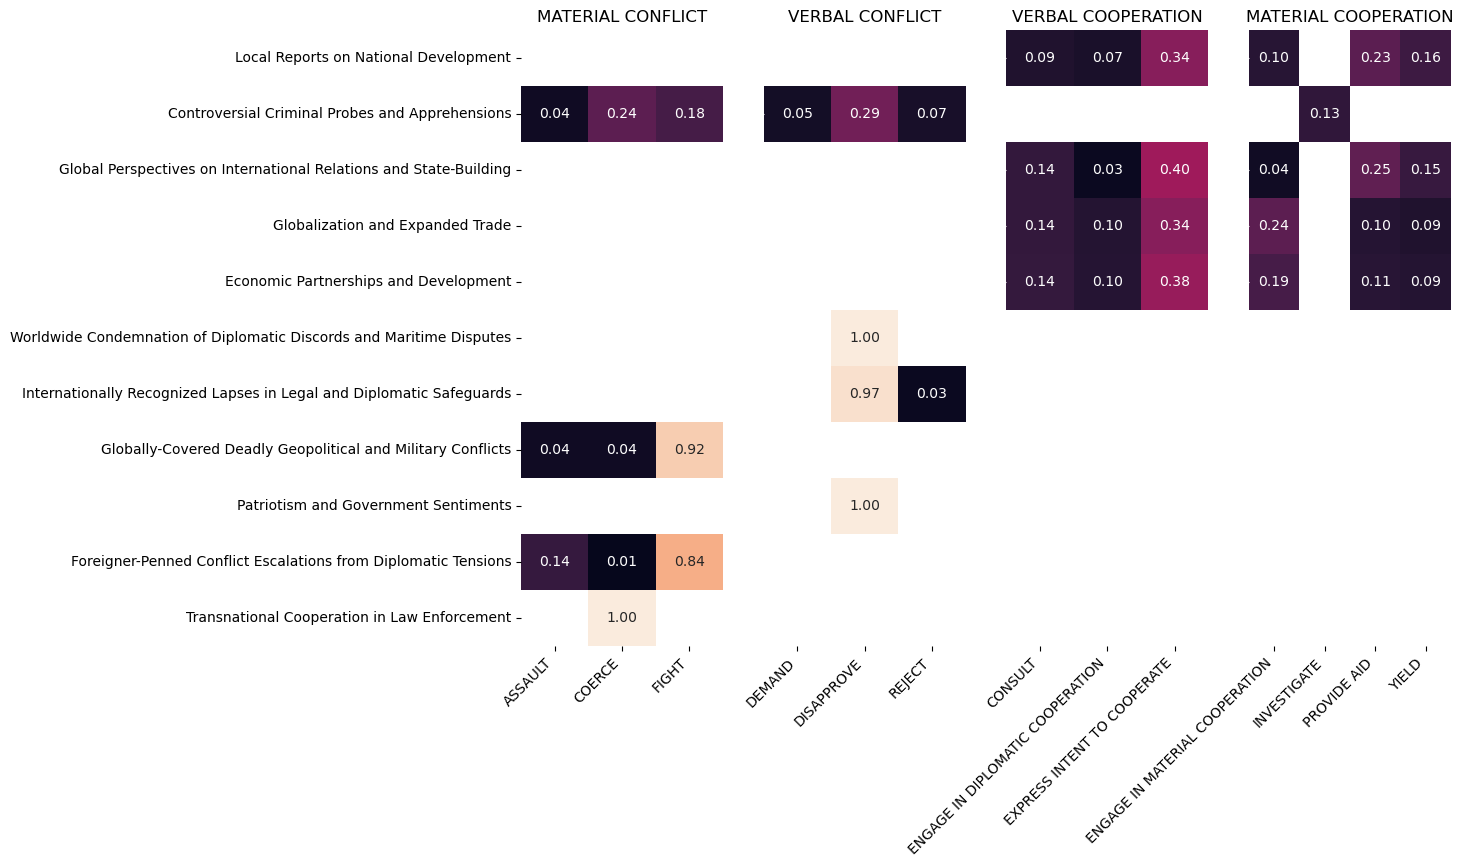

In [33]:
# Quadclass
tmp = profiling_df.pivot_table(index="label", columns=["quadclass", "eventrootdescription"], values=candidate, aggfunc="count").loc[order,]
tmp = tmp.div(tmp.sum(axis=1), axis=0)

fig, axes = plt.subplots(ncols=4, figsize=(12,8), sharey=True)

quadclasses = ["MATERIAL CONFLICT", "VERBAL CONFLICT", "VERBAL COOPERATION", "MATERIAL COOPERATION"]
for i, quadclass in enumerate(quadclasses):
    ax = axes[i]
    tmp_ = tmp.xs(quadclass, level=0, axis=1)
    _ = sns.heatmap(tmp_,  annot=True, cbar=False, fmt=".2f", vmin=0, vmax=1, ax=ax)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    _ = ax.set_xlabel("")
    _ = ax.set_ylabel("")
    _ = ax.set_title(quadclass)
    if i > 0:
        _ = ax.tick_params(axis="y", colors="white")

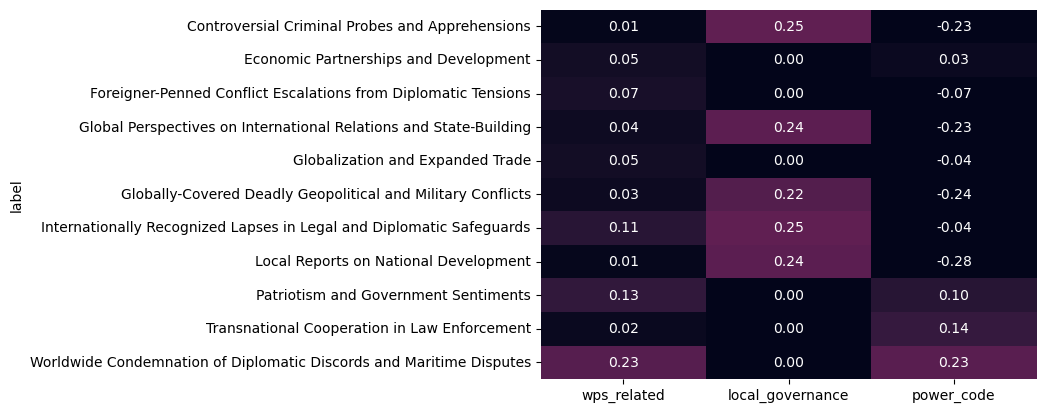

In [34]:
# Summarize bool descriptive flags
input_cols = num_cols + bool_cols + cat_cols
label_cols = list(candidate_map.keys())
desc_cols = [c for c in profiling_df.columns if c not in input_cols + label_cols]
tmp = profiling_df[desc_cols].select_dtypes([np.number, bool]).astype(int)
tmp["label"] = profiling_df["label"]
_ = sns.heatmap(tmp.iloc[:,1:].dropna().groupby("label").mean(), cbar=False, annot=True, fmt=".2f", vmin=0, vmax=1)